# Analyze modifications of the gamma rule on the entire MNIST CNNnetwork

In [31]:
1

1

#### Loading stuff

In [1]:
%load_ext autoreload
%autoreload 2

import os
from tqdm import tqdm
import copy
from functools import partial

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# import quantus

from util.util_cnn import CNNModel, data_loaders, first_mnist_batch, test, \
                params_to_filename, params_from_filename, load_mnist_v4_models

from util.util_gamma_rule import \
                plot_vals_lineplot, plot_multiplicative_change, \
                col_norms_for_matrices, \
                global_conv_matrix_from_pytorch_layer, \
                calc_mats_batch, calc_vals_batch

from util.util_lrp import layerwise_forward_pass, compute_relevancies, LRP_global_mat, calc_mats_batch_functional, forward_and_explain
from util.util_matrix_norms import calc_norm_dict
from util.util_data_summary import *
from util.util_pickle import *
from util.naming import *

from learning_lrp import perturb_point

import util.util_tutorial as tut_utils

no display found. Using non-interactive Agg backend


In [2]:
del CNNModel
from util.util_cnn import CNNModel

In [2]:
%matplotlib inline

In [3]:
# load data and pretrained models
data, target = first_mnist_batch()

model_dict = load_mnist_v4_models()
model_d3 = model_dict[d3_tag]

In [4]:
ll =list(model_dict.keys())
ll.sort()
ll

['Fs-11-11-11-11_seed-0',
 'Fs-11-11-11-11_seed-1',
 'Fs-3-3-3-3-3-3-3-3_seed-0',
 'Fs-3-3-3-3-3-3-3-3_seed-1',
 'Fs-3-3-3-3-3-3_seed-0',
 'Fs-3-3-3-3-3-3_seed-1',
 'Fs-3-3-3-3_seed-0',
 'Fs-3-3-3-3_seed-1',
 'Fs-3-3_seed-0',
 'Fs-3-3_seed-1',
 'Fs-5-5-5-5-5-5-5-5_seed-0',
 'Fs-5-5-5-5-5-5-5-5_seed-1',
 'Fs-5-5-5-5-5-5_seed-0',
 'Fs-5-5-5-5-5-5_seed-1',
 'Fs-5-5-5-5_seed-0',
 'Fs-5-5-5-5_seed-1',
 'Fs-5-5_seed-0',
 'Fs-5-5_seed-1',
 'Fs-7-7-7-7-7-7-7-7_seed-0',
 'Fs-7-7-7-7-7-7-7-7_seed-1',
 'Fs-7-7-7-7-7-7_seed-0',
 'Fs-7-7-7-7-7-7_seed-1',
 'Fs-7-7-7-7_seed-0',
 'Fs-7-7-7-7_seed-1',
 'Fs-7-7_seed-0',
 'Fs-7-7_seed-1',
 'Fs-9-9-9-9_seed-0',
 'Fs-9-9-9-9_seed-1',
 'cb1-16-16_cb2-32-32_seed-0',
 'cb1-16_cb2-32_seed-0',
 'cb1-16_cb2-32_seed-1',
 'cb1-16_cb2-32_seed-2',
 'cb1-16_cb2-32_seed-3',
 'cb1-8-8-8_cb2-16-16-16_seed-0',
 'cb1-8-8-8_cb2-16-16-16_seed-1',
 'cb1-8-8-8_cb2-16-16-16_seed-2',
 'cb1-8-8-8_cb2-16-16-16_seed-3',
 'cb1-8-8_cb2-16-16_seed-0',
 'cb1-8-8_cb2-16-16_seed-1',
 'c

In [5]:
train_loader, test_loader = data_loaders()

In [6]:
s4f3 = model_dict[s4f3_tag]
s4f5 = model_dict[s4f5_tag]
s4f7 = model_dict[s4f7_tag]
s6f3 = model_dict[s6f3_tag]
s6f5 = model_dict[s6f5_tag]
s6f7 = model_dict[s6f7_tag]
s8f7 = model_dict[s8f7_tag]

In [15]:
print('s4f3:', end='')
test(s4f3, 'cpu', test_loader)
print('s4f5:', end='')
test(s4f5, 'cpu', test_loader)
print('s4f7:', end='')
test(s4f7, 'cpu', test_loader)
print('s6f3:', end='')
test(s6f3, 'cpu', test_loader)
print('s6f5:', end='')
test(s6f5, 'cpu', test_loader)
print('s6f7:', end='')
test(s6f7, 'cpu', test_loader)
print('s8f7:', end='')
test(s8f7, 'cpu', test_loader)

s4f3:
Test set: Average loss: -44.6345, Accuracy: 8178/8400 (97%)

s4f5:
Test set: Average loss: -11.7918, Accuracy: 7231/8400 (86%)

s4f7:
Test set: Average loss: -52.6007, Accuracy: 8288/8400 (99%)

s6f3:
Test set: Average loss: -52.9960, Accuracy: 8211/8400 (98%)

s6f5:
Test set: Average loss: -0.0000, Accuracy: 647/8400 (8%)

s6f7:
Test set: Average loss: -87.3865, Accuracy: 8189/8400 (97%)

s8f7:
Test set: Average loss: -0.0242, Accuracy: 909/8400 (11%)



### Print layers and hidden activaitonn shape

In [7]:
A, layers = layerwise_forward_pass(s4f3, data)
A_shapes = [a.shape[1:] for a in A]

for i, (a, l) in enumerate(zip(A, layers)):
    print(i, "Input:", list(a.shape), '->', str(l).split('(')[0],
    (list(l.weight.shape)) if isinstance(l, torch.nn.Conv2d) else "")

10 torch.Size([100, 1, 28, 28]) [Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(), Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(), Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(), Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(), AvgPool2d(kernel_size=28, stride=28, padding=0), Flatten(start_dim=1, end_dim=-1)]
0 Input: [100, 1, 28, 28] -> Conv2d [10, 1, 3, 3]
1 Input: [100, 10, 28, 28] -> ReLU 
2 Input: [100, 10, 28, 28] -> Conv2d [10, 10, 3, 3]
3 Input: [100, 10, 28, 28] -> ReLU 
4 Input: [100, 10, 28, 28] -> Conv2d [10, 10, 3, 3]
5 Input: [100, 10, 28, 28] -> ReLU 
6 Input: [100, 10, 28, 28] -> Conv2d [10, 10, 3, 3]
7 Input: [100, 10, 28, 28] -> ReLU 
8 Input: [100, 10, 28, 28] -> AvgPool2d 
9 Input: [100, 10, 1, 1] -> Flatten 


In [8]:
A, layers = layerwise_forward_pass(s4f3, data)
A_shapes = [a.shape[1:] for a in A]

for i, (a, l) in enumerate(zip(A, layers)):
    if isinstance(l, torch.nn.Conv2d) or isinstance(l, torch.nn.AvgPool2d):
        print(i, "Input:", list(a.shape), '>=0:', float((a>0).mean(dtype=float)))

10 torch.Size([100, 1, 28, 28]) [Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(), Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(), Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(), Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(), AvgPool2d(kernel_size=28, stride=28, padding=0), Flatten(start_dim=1, end_dim=-1)]
0 Input: [100, 1, 28, 28] >=0: 0.19683673469387755
2 Input: [100, 10, 28, 28] >=0: 0.4236811224489796
4 Input: [100, 10, 28, 28] >=0: 0.2916441326530612
6 Input: [100, 10, 28, 28] >=0: 0.2472359693877551
8 Input: [100, 10, 28, 28] >=0: 0.3322168367346939


In [9]:
A, layers = layerwise_forward_pass(s4f5, data)
A_shapes = [a.shape[1:] for a in A]

for i, (a, l) in enumerate(zip(A, layers)):
    if isinstance(l, torch.nn.Conv2d) or isinstance(l, torch.nn.AvgPool2d):
        print(i, "Input:", list(a.shape), '>=0:', float((a>0).mean(dtype=float)))

10 torch.Size([100, 1, 28, 28]) [Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), ReLU(), Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), ReLU(), Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), ReLU(), Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), ReLU(), AvgPool2d(kernel_size=28, stride=28, padding=0), Flatten(start_dim=1, end_dim=-1)]
0 Input: [100, 1, 28, 28] >=0: 0.19683673469387755
2 Input: [100, 10, 28, 28] >=0: 0.11646811224489796
4 Input: [100, 10, 28, 28] >=0: 0.23477295918367347
6 Input: [100, 10, 28, 28] >=0: 0.437218112244898
8 Input: [100, 10, 28, 28] >=0: 0.016988520408163264


In [10]:
A, layers = layerwise_forward_pass(s4f7, data)
A_shapes = [a.shape[1:] for a in A]

for i, (a, l) in enumerate(zip(A, layers)):
    if isinstance(l, torch.nn.Conv2d) or isinstance(l, torch.nn.AvgPool2d):
        print(i, "Input:", list(a.shape), '>=0:', float((a>0).mean(dtype=float)))

10 torch.Size([100, 1, 28, 28]) [Conv2d(1, 10, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3)), ReLU(), Conv2d(10, 10, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3)), ReLU(), Conv2d(10, 10, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3)), ReLU(), Conv2d(10, 10, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3)), ReLU(), AvgPool2d(kernel_size=28, stride=28, padding=0), Flatten(start_dim=1, end_dim=-1)]
0 Input: [100, 1, 28, 28] >=0: 0.19683673469387755
2 Input: [100, 10, 28, 28] >=0: 0.25634183673469385
4 Input: [100, 10, 28, 28] >=0: 0.2364311224489796
6 Input: [100, 10, 28, 28] >=0: 0.2074719387755102
8 Input: [100, 10, 28, 28] >=0: 0.4562920918367347


### Global LRP, modify individual Layers with Gamma

In [ ]:
n_points = 20 # len(data)
mat_funcs = [partial(LRP_global_mat, model=s4f3, l_lb=l_ub-2, l_ub=l_ub, l_inp=1) for l_ub in s4_after_conv_layer]
LRP_m0_to_1__individual_gamma__gammas40 = calc_mats_batch_functional(mat_funcs, gammas40, data[:n_points].reshape((n_points, -1)))

In [11]:
if False:
    svals__m0_to_1__individual_gamma__gammas40, _ = calc_vals_batch(LRP_m0_to_1__individual_gamma__gammas40, num_vals='auto', tqdm_for='weight')
    save_data('s4f3', 'svals__m0_to_1__individual_gamma__gammas40', svals__m0_to_1__individual_gamma__gammas40)
else:
    svals__m0_to_1__individual_gamma__gammas40 = load_data('s4f3', 'svals__m0_to_1__individual_gamma__gammas40')
    
svals__m0_to_1__individual_gamma__gammas40.shape

(3, 20, 40, 10)

In [ ]:
svals__m0_to_1__individual_gamma__gammas40[:, :1, -1:]

array([[[[0.2679016 , 0.07746796, 0.06486592, 0.05504304, 0.04383937,
          0.03719012, 0.02772311, 0.02538912, 0.02359178, 0.01705075]]],


       [[[0.30438131, 0.08065581, 0.06099296, 0.04591727, 0.03572259,
          0.0309213 , 0.02220082, 0.01938414, 0.01554924, 0.01443046]]],


       [[[0.38150144, 0.10920021, 0.0807118 , 0.06693881, 0.05541784,
          0.04567691, 0.03529423, 0.03113285, 0.02628013, 0.01680503]]]])

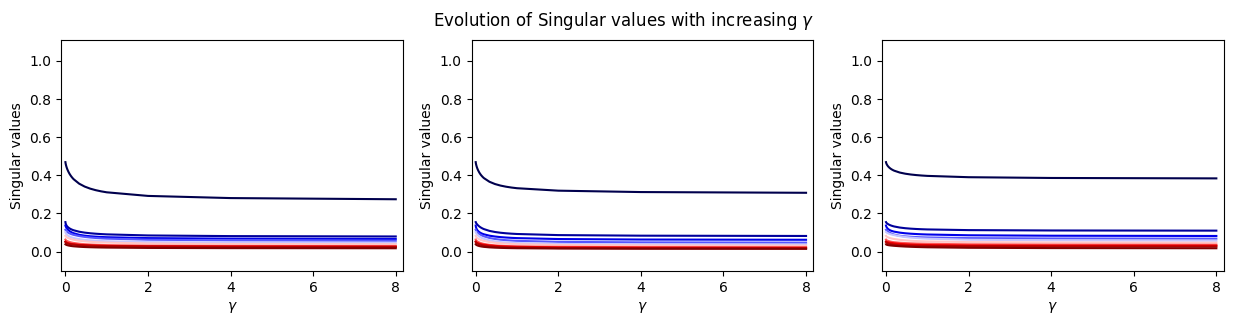

In [ ]:
plot_vals_lineplot(svals__m0_to_1__individual_gamma__gammas40[:, :1], gammas40, xlim=8, ylim=1, num_vals_total=200, colormap='seismic')

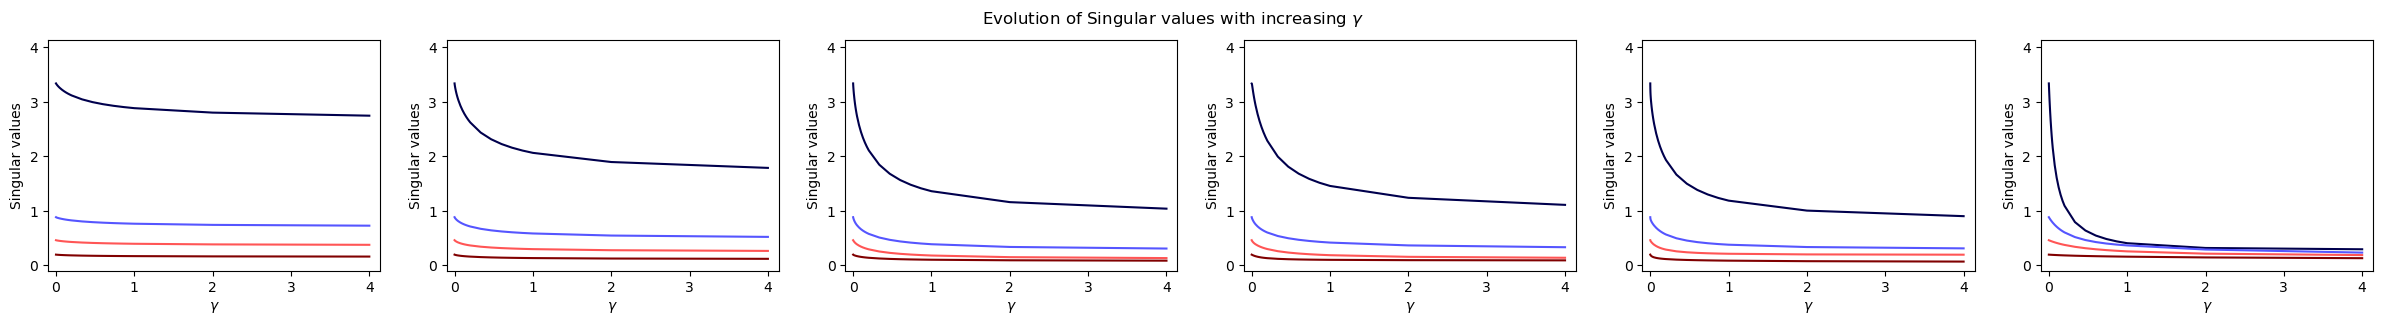

In [ ]:
# Comparison D3 network:
plot_vals_lineplot(svals__m0_to_1__individual_gamma__gammas40[:, :1], gammas40, xlim=4, num_vals_total=200, colormap='seismic')

#### Unnormalized multiplicative change

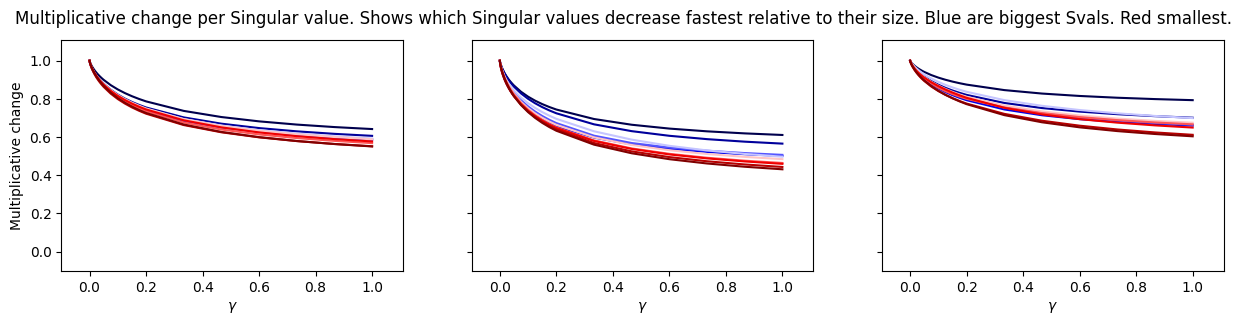

In [ ]:
# harmoic mean as a summary - y axis linear between 0 and 1
plot_multiplicative_change(svals__m0_to_1__individual_gamma__gammas40, gammas40, normalize=False, hmean='points', yscale='linear', xlim=1, ylim=(0,1), sharey=True)

point 0


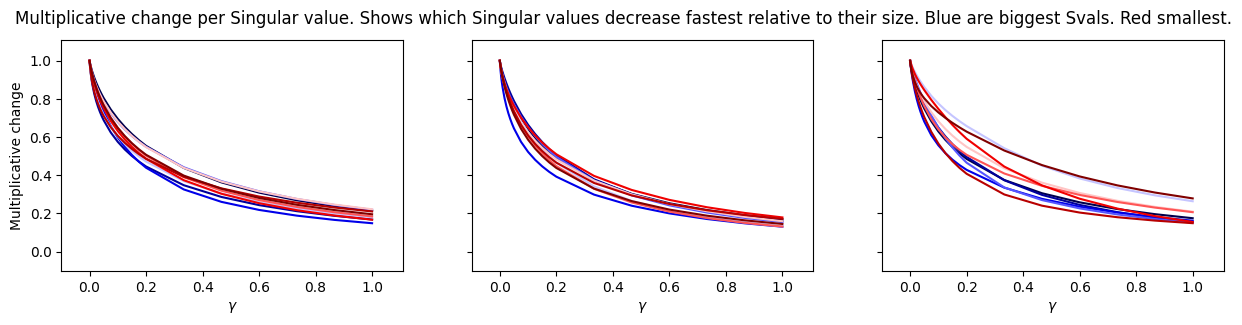

point 1


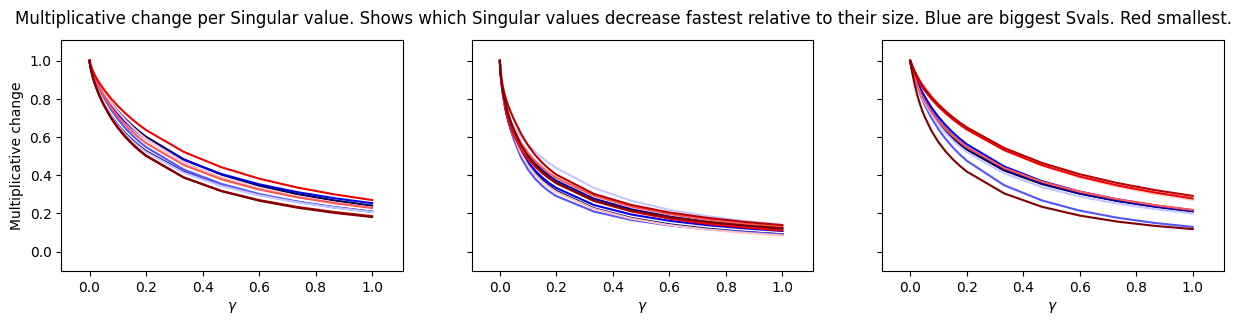

point 2


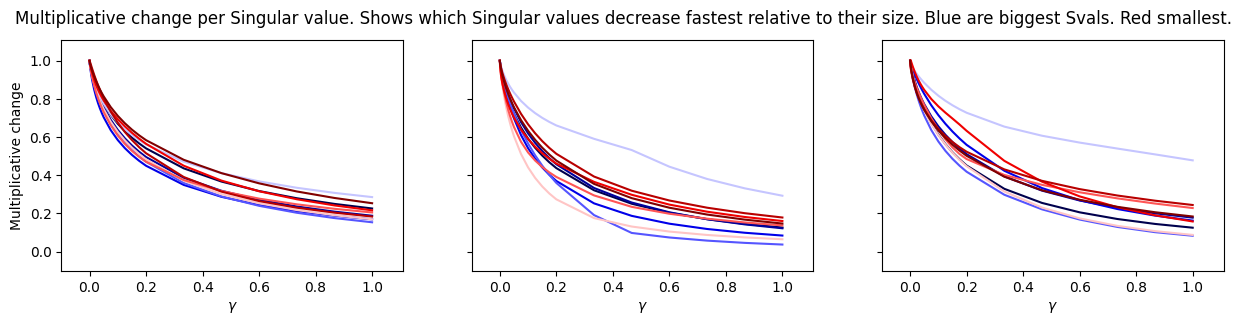

point 3


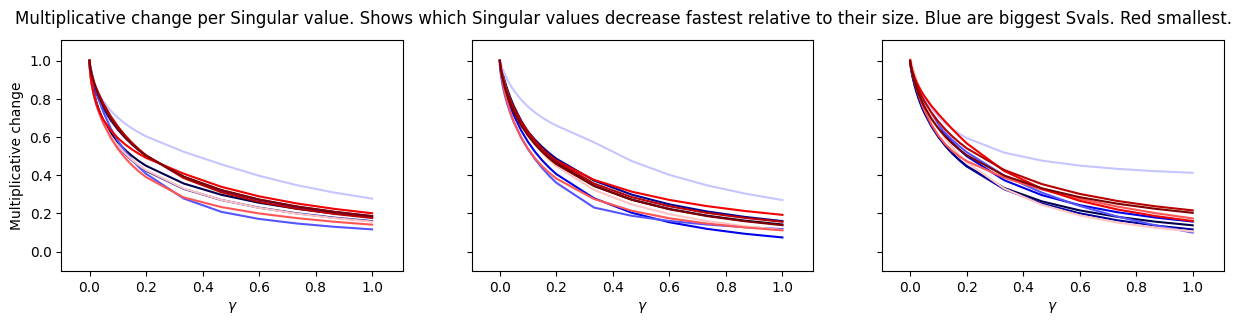

point 4


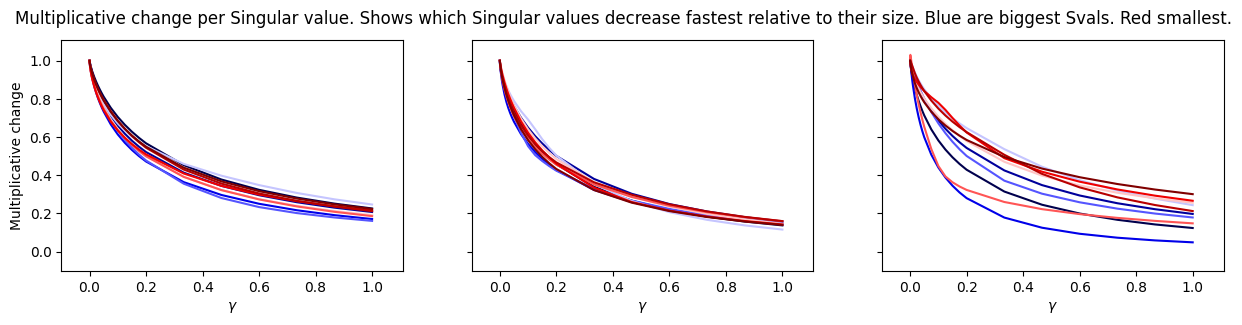

point 5


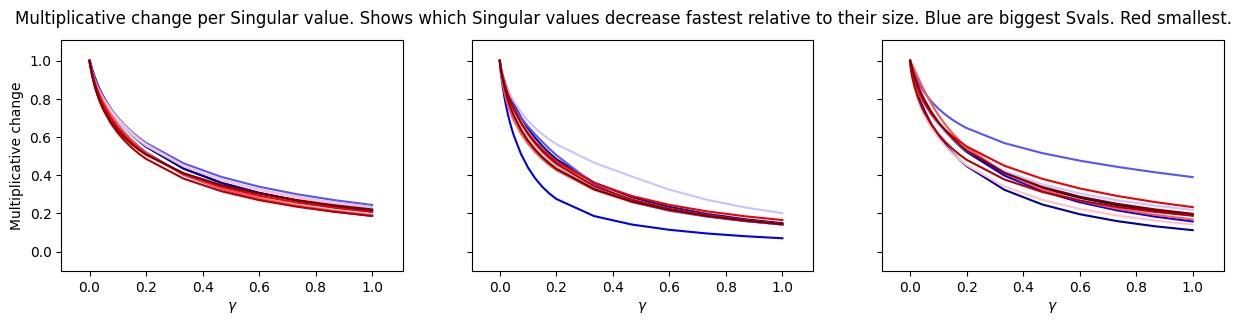

point 6


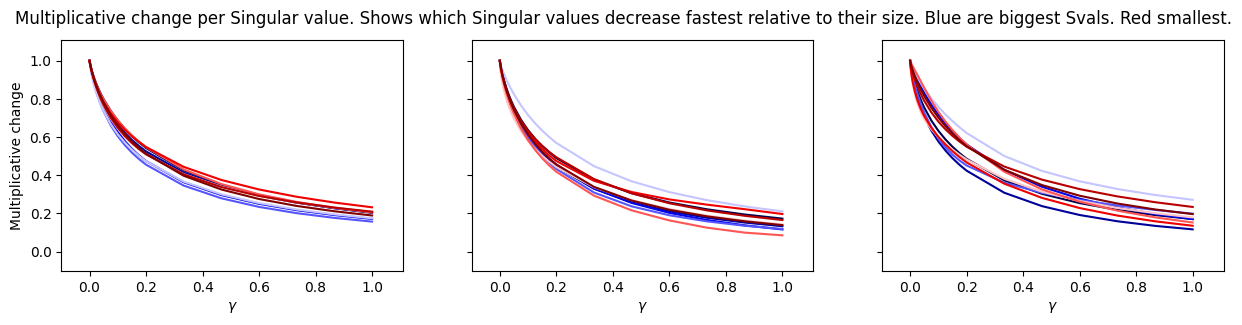

point 7


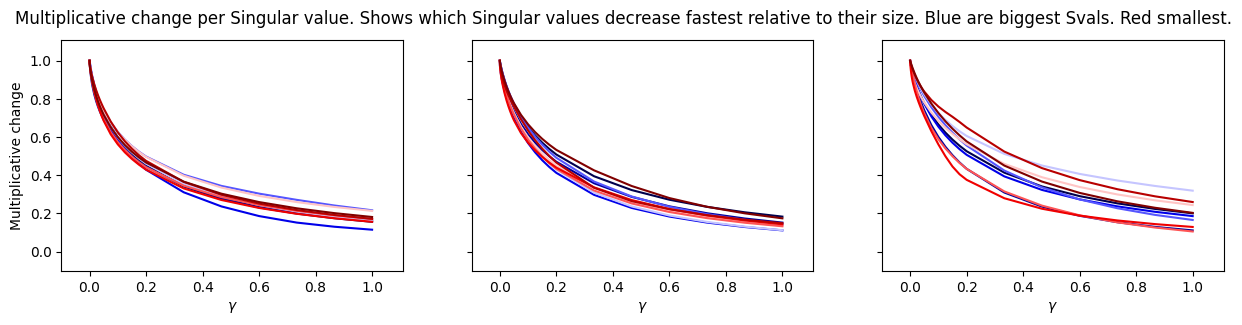

point 8


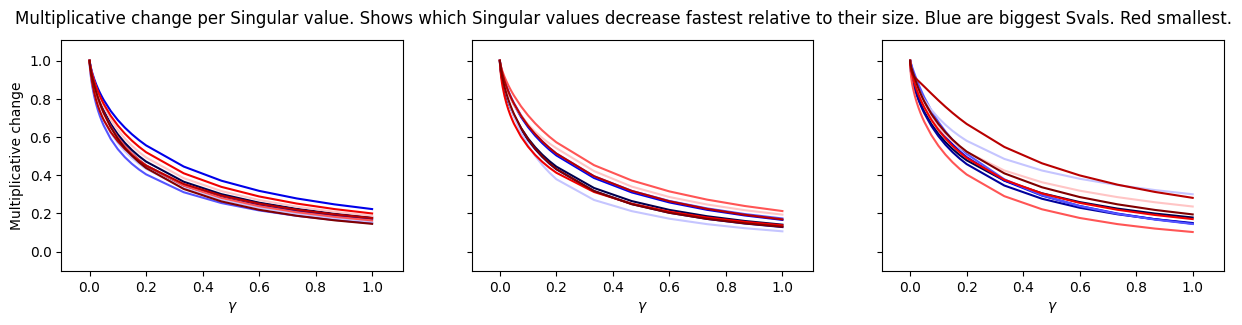

point 9


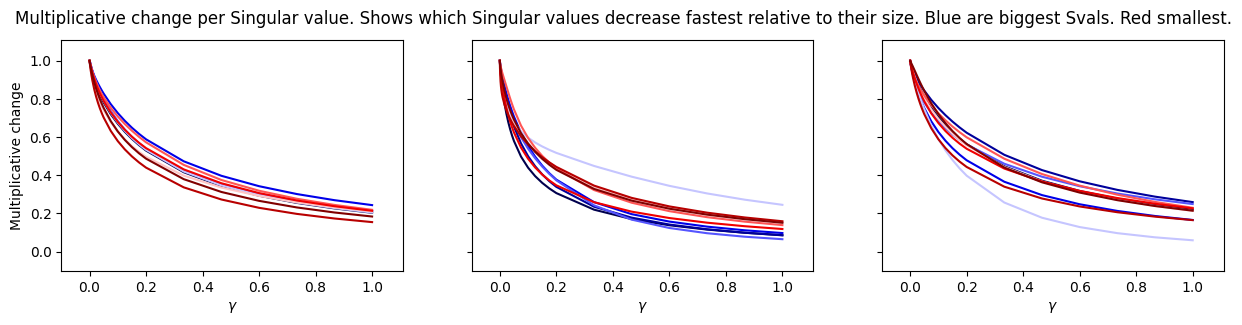

In [ ]:
# individual points - y axis linear between 0 and 1
for p in range(10):
    print('point', p)
    plot_multiplicative_change(svals__m0_to_1__individual_gamma__gammas40[:, p:p+1], gammas40, normalize=True, yscale='linear', xlim=1, ylim=(0,1), sharey=True)

## Repeat same individual layer, modify only one of them with gamma.

In [129]:
i=4
s4f3_mod = copy.deepcopy(s4f3)
with torch.no_grad():
    s4f3_mod.seq[2] = s4f3.seq[i]
    s4f3_mod.seq[4] = s4f3.seq[i]
    s4f3_mod.seq[6] = s4f3.seq[i]

In [138]:
test(s4f3, 'cpu', test_loader)
test(mod, 'cpu', test_loader)


Test set: Average loss: -44.6345, Accuracy: 8178/8400 (97%)


Test set: Average loss: -41.9914, Accuracy: 1053/8400 (13%)



In [131]:
n_points = 5 # len(data)
mat_funcs = [partial(LRP_global_mat, model=s4f3_mod, l_lb=l_ub-2, l_ub=l_ub, l_inp=1) for l_ub in s4_after_conv_layer]
LRP_m0_to_1__individual_gamma__gammas40__s4f3_mod = calc_mats_batch_functional(mat_funcs, gammas40, data[:n_points].reshape((n_points, -1)))

100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


In [132]:
if True:
    svals__m0_to_1__individual_gamma__gammas40__s4f3_mod, _ = calc_vals_batch(LRP_m0_to_1__individual_gamma__gammas40__s4f3_mod, num_vals='auto', tqdm_for='weight')
    save_data('s4f3_mod', 'svals__m0_to_1__individual_gamma__gammas40', svals__m0_to_1__individual_gamma__gammas40__s4f3_mod)
else:
    svals__m0_to_1__individual_gamma__gammas40__s4f3_mod = load_data('s4f3_mod', 'svals__m0_to_1__individual_gamma__gammas40')
    
svals__m0_to_1__individual_gamma__gammas40__s4f3_mod.shape

(3, 5, 40, 10)

#### Notes

- Changing the filter size of the last layer between 3 and 7 doesn't affect Sval results much:
````
mod = copy.deepcopy(s4f7)
with torch.no_grad():
    mod.seq[2] = s4f3.seq[2]
    mod.seq[4] = s4f3.seq[4]
    mod.seq[6] = s4f7.seq[6]
````	

In [260]:
A, layers = layerwise_forward_pass(mod, data)
A_shapes = [a.shape[1:] for a in A]

for i, (a, l) in enumerate(zip(A, layers)):
    if isinstance(l, torch.nn.Conv2d) or isinstance(l, torch.nn.AvgPool2d) or 1:
        print(i, "Input:", list(a.shape), '>=0:', float((a>0).mean(dtype=float)))

0 Input: [100, 1, 28, 28] >=0: 0.19683673469387755
1 Input: [100, 10, 28, 28] >=0: 0.5716020408163265
2 Input: [100, 10, 28, 28] >=0: 0.5716020408163265
3 Input: [100, 10, 28, 28] >=0: 0.4613545918367347
4 Input: [100, 10, 28, 28] >=0: 0.4613545918367347
5 Input: [100, 10, 28, 28] >=0: 0.4424936224489796
6 Input: [100, 10, 28, 28] >=0: 0.4424936224489796
7 Input: [100, 10, 28, 28] >=0: 0.5455242346938776
8 Input: [100, 10, 28, 28] >=0: 0.5455242346938776
9 Input: [100, 10, 28, 28] >=0: 0.5522895408163265
10 Input: [100, 10, 28, 28] >=0: 0.5522895408163265
11 Input: [100, 10, 28, 28] >=0: 0.5058354591836735
12 Input: [100, 10, 28, 28] >=0: 0.5058354591836735
13 Input: [100, 10, 1, 1] >=0: 1.0


In [261]:
mod

CNNModel(
  (seq): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(10, 10, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (11): ReLU()
    (12): AvgPool2d(kernel_size=28, stride=28, padding=0)
    (13): Flatten(start_dim=1, end_dim=-1)
  )
)

In [197]:
n_points = 5 # len(data)
mat_funcs = [partial(LRP_global_mat, model=mod, l_lb=l_ub-2, l_ub=l_ub, l_inp=1) for l_ub in mod_after_conv_layer]
LRP_m0_to_1__individual_gamma__gammas40__mod = calc_mats_batch_functional(mat_funcs, gammas40, data[:n_points].reshape((n_points, -1)))

svals__m0_to_1__individual_gamma__gammas40__mod, _ = calc_vals_batch(LRP_m0_to_1__individual_gamma__gammas40__mod, num_vals='auto', tqdm_for='weight')

100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


#### Manually modify filter sizes in S4

In [213]:
mod = copy.deepcopy(s4f3)
with torch.no_grad():
    mod.seq[2] = s4f7.seq[2]
    mod.seq[4] = s4f7.seq[2]
    mod.seq[6] = s4f7.seq[2]

mod_after_conv_layer = s4_after_conv_layer

n_points = 5 # len(data)
mat_funcs = [partial(LRP_global_mat, model=mod, l_lb=l_ub-2, l_ub=l_ub, l_inp=1) for l_ub in mod_after_conv_layer]
LRP_m0_to_1__individual_gamma__gammas40__mod = calc_mats_batch_functional(mat_funcs, gammas40, data[:n_points].reshape((n_points, -1)))

# svals__m0_to_1__individual_gamma__gammas40__mod, _ = calc_vals_batch(LRP_m0_to_1__individual_gamma__gammas40__mod, num_vals='auto', tqdm_for='weight')
svals__m0_to_1__individual_gamma__gammas5__mod, svecs__m0_to_1__individual_gamma__gammas5__mod \
      = calc_vals_batch(LRP_m0_to_1__individual_gamma__gammas40__mod, num_vals='auto', tqdm_for='weight', return_vecs=True)

100%|██████████| 3/3 [00:08<00:00,  2.89s/it]


#### Manually modify filter sizes in S6

In [8]:
mod = copy.deepcopy(s6f3)
with torch.no_grad():
    for ind in s6_after_conv_layer:
        mod.seq[ind-1] = s6f3.seq[2]

# mod.seq[s6_after_conv_layer[-1]-1] = s6f7.seq[2]


# with torch.no_grad():
#     mod.seq[2] = s4f7.seq[2]
#     mod.seq[4] = s4f7.seq[2]
#     mod.seq[6] = s4f7.seq[2]

mod_after_conv_layer = s6_after_conv_layer

In [9]:

n_points = 5 # len(data)
mat_funcs = [partial(LRP_global_mat, model=mod, l_lb=l_ub-2, l_ub=l_ub, l_inp=1) for l_ub in mod_after_conv_layer]
LRP_m0_to_1__individual_gamma__gammas40__mod = calc_mats_batch_functional(mat_funcs, gammas40, data[:n_points].reshape((n_points, -1)))

svals__m0_to_1__individual_gamma__gammas40__mod, _ = calc_vals_batch(LRP_m0_to_1__individual_gamma__gammas40__mod, num_vals='auto', tqdm_for='weight')

100%|██████████| 5/5 [00:25<00:00,  5.10s/it]


In [244]:
svals__m0_to_1__individual_gamma__gammas40__mod = svals__m0_to_1__individual_gamma__gammas40__s6f3

In [246]:
svals__m0_to_1__individual_gamma__gammas40__mod = svals__m0_to_1__individual_gamma__gammas40__s6f7

#### Manually insert MaxPool layers

In [18]:
from torch.nn import MaxPool2d
layers = list(s4f3.seq)
layers.insert(4, MaxPool2d(2))
layers.insert(7, MaxPool2d(2))
layers[-2].kernel_size = int(28 / 2**2) # The Global Avaerage pool now only pools over a 7x7 field

mod_after_conv_layer = [3, 6, 9]
mod = CNNModel(layers=layers)


In [ ]:

n_points = 5 # len(data)
mat_funcs = [partial(LRP_global_mat, model=s4f3_mod, l_lb=l_ub-2, l_ub=l_ub, l_inp=1) for l_ub in mod_after_conv_layer]
LRP_m0_to_1__individual_gamma__gammas40__mod = calc_mats_batch_functional(mat_funcs, gammas40, data[:n_points].reshape((n_points, -1)))

svals__m0_to_1__individual_gamma__gammas40__mod, _ = calc_vals_batch(LRP_m0_to_1__individual_gamma__gammas40__mod, num_vals='auto', tqdm_for='weight')

#### Plot

point 0


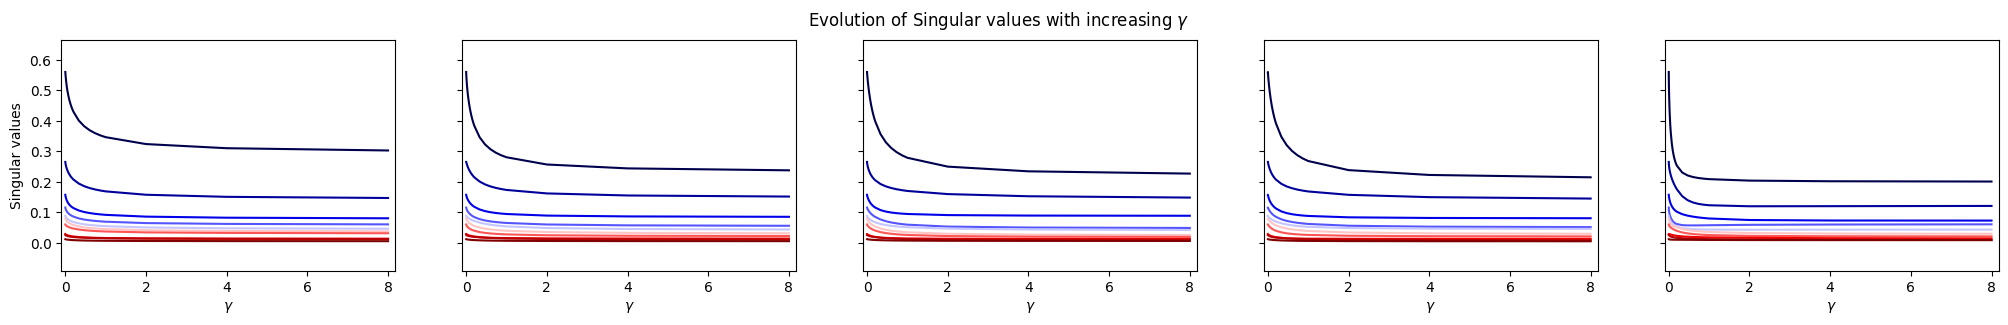

point 1


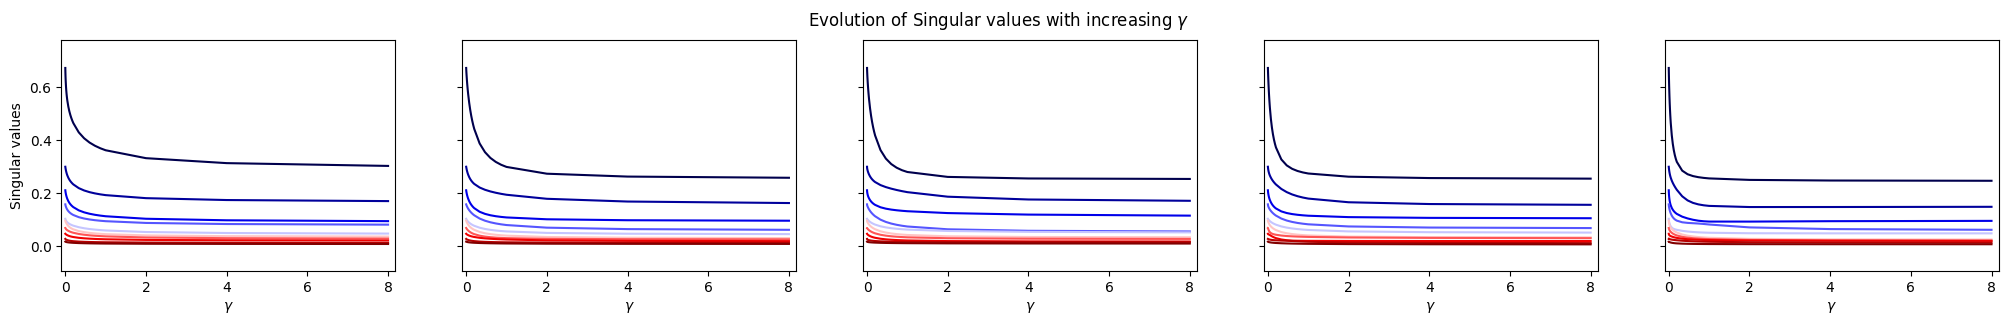

point 2


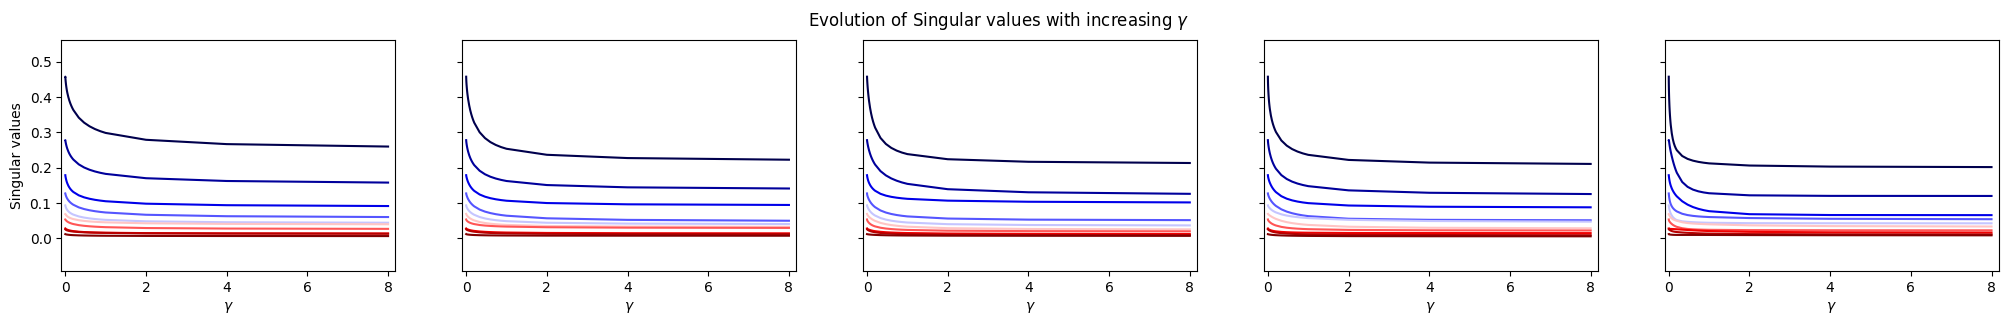

point 3


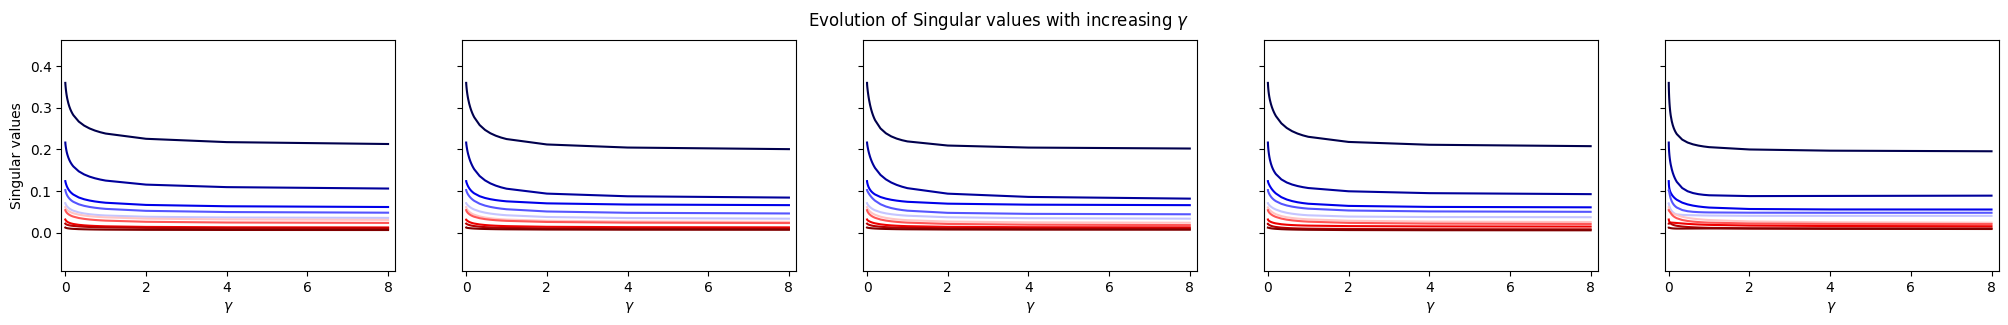

point 4


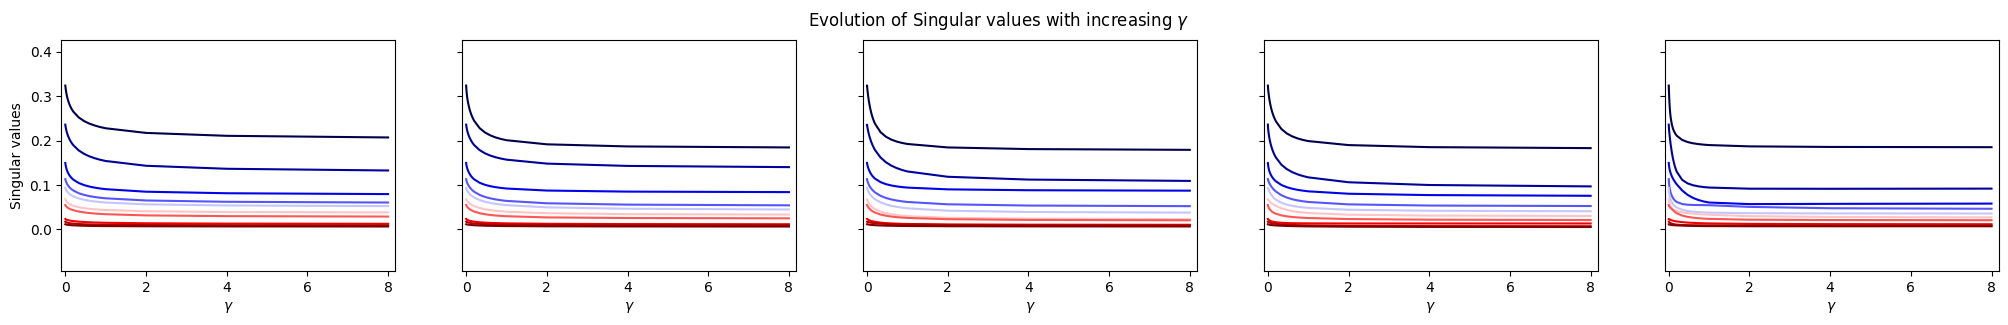

In [319]:
for i in range(5):
    print('point', i)
    plot_vals_lineplot(svals__m0_to_1__individual_gamma__gammas40__mod[:, i:i+1], gammas40, xlim=8, ylim='p100', sharey=True, num_vals_total=200, colormap='seismic')

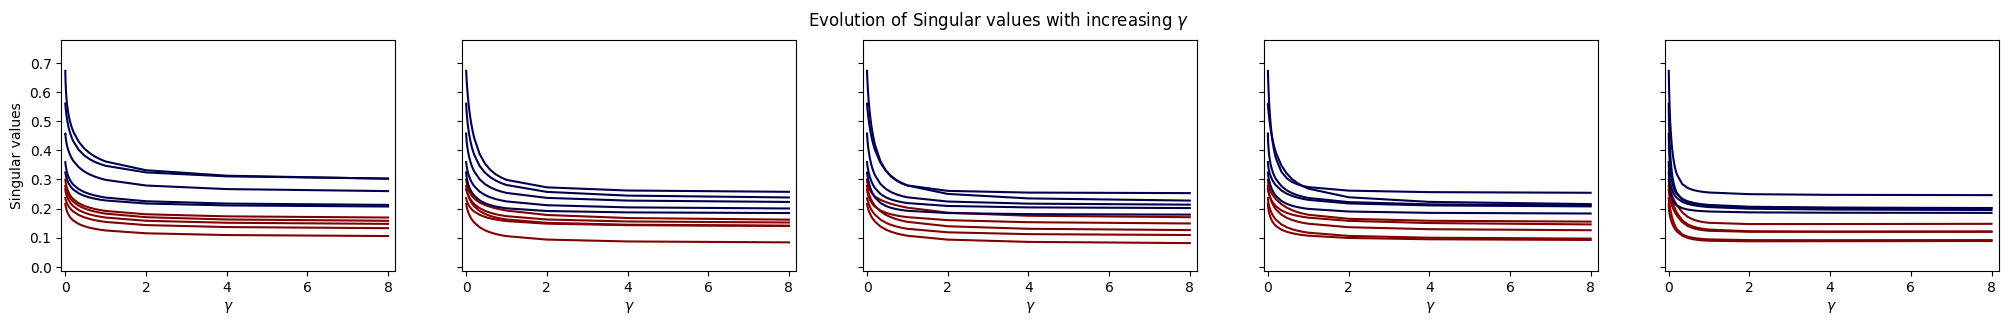

In [320]:
plot_vals_lineplot(svals__m0_to_1__individual_gamma__gammas40__mod[:, :, :, :2], gammas40, xlim=8, ylim='p100', sharey=True, num_vals_total=200, colormap='seismic')

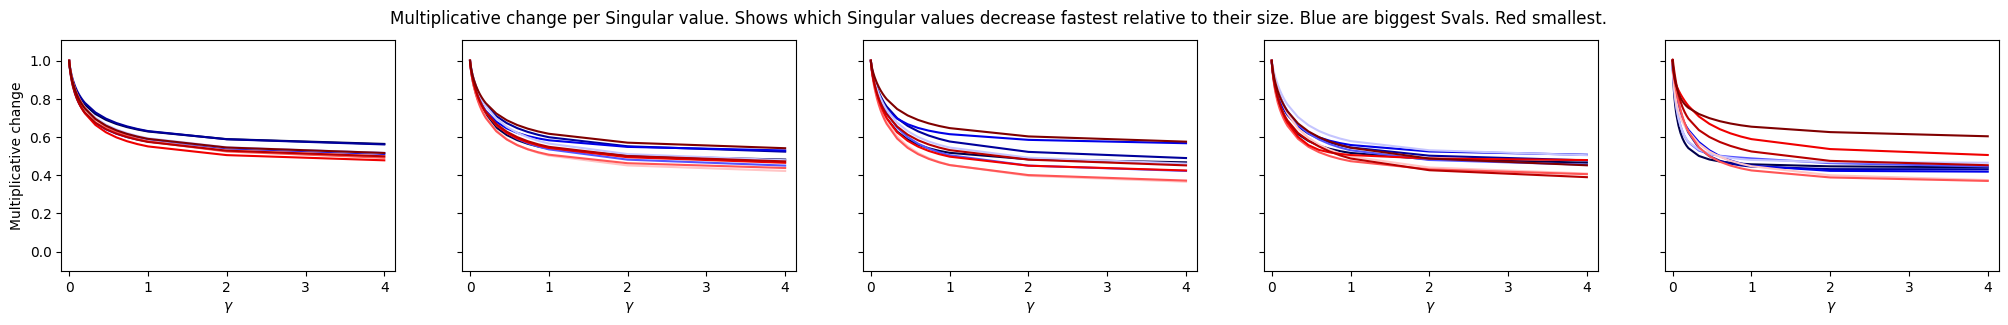

In [10]:
# harmoic mean as a summary - y axis linear between 0 and 1
plot_multiplicative_change(svals__m0_to_1__individual_gamma__gammas40__mod, gammas40, normalize=False, hmean='points', yscale='linear', xlim=4, ylim=(0,1), sharey=True)

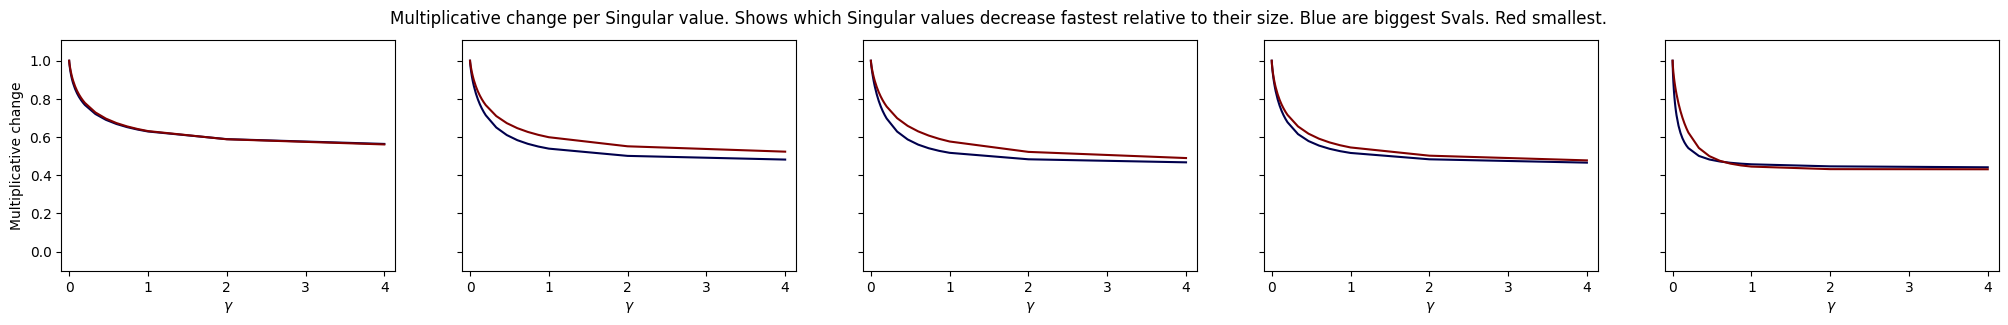

In [11]:
# harmoic mean as a summary - y axis linear between 0 and 1
plot_multiplicative_change(svals__m0_to_1__individual_gamma__gammas40__mod[:, :, :, :2], gammas40, normalize=False, hmean='points', yscale='linear', xlim=4, ylim=(0,1), sharey=True)

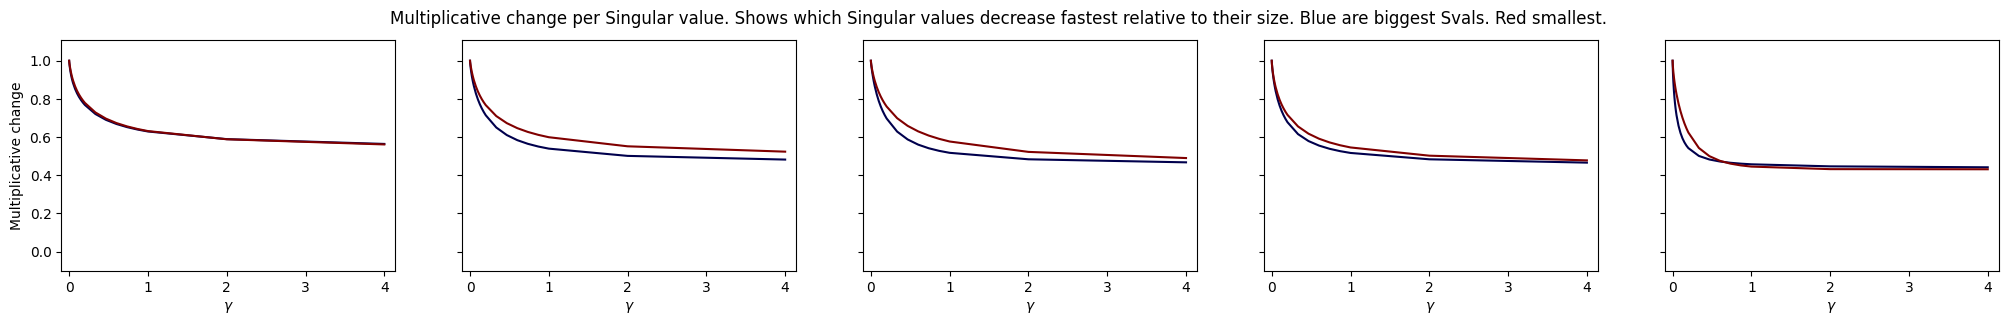

In [ ]:
# harmoic mean as a summary - y axis linear between 0 and 1
plot_multiplicative_change(svals__m0_to_1__individual_gamma__gammas40__mod[:, :, :, :2], gammas40, normalize=False, hmean='points', yscale='linear', xlim=4, ylim=(0,1), sharey=True)

## Individual layers

In [ ]:
n_points = 20 # len(data)
mat_funcs = [partial(LRP_global_mat, model=s4f3, l_lb=l_ub-2, l_ub=l_ub, l_inp=1) for l_ub in s4_after_conv_layer]
LRP_m0_to_1__individual_gamma__gammas40 = calc_mats_batch_functional(mat_funcs, gammas40, data[:n_points].reshape((n_points, -1)))





100%|██████████| 3/3 [00:13<00:00,  4.35s/it]


### mod network

In [23]:
mod

CNNModel(
  (seq): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): AvgPool2d(kernel_size=7, stride=28, padding=0)
    (11): Flatten(start_dim=1, end_dim=-1)
  )
)

In [29]:
n_points=20
mat_funcs = [partial(LRP_global_mat, model=mod, l_inp=l_out-2, l_out=l_out, delete_unactivated_subnetwork=True) for l_out in mod_after_conv_layer]
LRP__individual_layer__gammas5__mod = calc_mats_batch_functional(mat_funcs, gammas5, data[:n_points].reshape((n_points, -1)))

100%|██████████| 5/5 [09:36<00:00, 115.36s/it]


In [30]:
LRP__individual_layer__gammas5__mod.shape, LRP__individual_layer__gammas5__mod[0,0,:]

((5, 20, 5),
 array([<4507x3643 sparse array of type '<class 'numpy.float32'>'
        	with 180421 stored elements in COOrdinate format>       ,
        <4507x3643 sparse array of type '<class 'numpy.float32'>'
        	with 180421 stored elements in COOrdinate format>       ,
        <4507x3643 sparse array of type '<class 'numpy.float32'>'
        	with 180421 stored elements in COOrdinate format>       ,
        <4507x3643 sparse array of type '<class 'numpy.float32'>'
        	with 180421 stored elements in COOrdinate format>       ,
        <4507x3643 sparse array of type '<class 'numpy.float32'>'
        	with 180421 stored elements in COOrdinate format>       ],
       dtype=object))

In [31]:
svals__individual_layer__gammas5__mod, _ = calc_vals_batch(LRP__individual_layer__gammas5__mod, num_vals=1, tqdm_for='point')

20it [00:05,  3.88it/s]
20it [00:03,  6.42it/s]
20it [00:02,  6.88it/s]
20it [00:03,  5.74it/s]
20it [00:04,  4.85it/s]


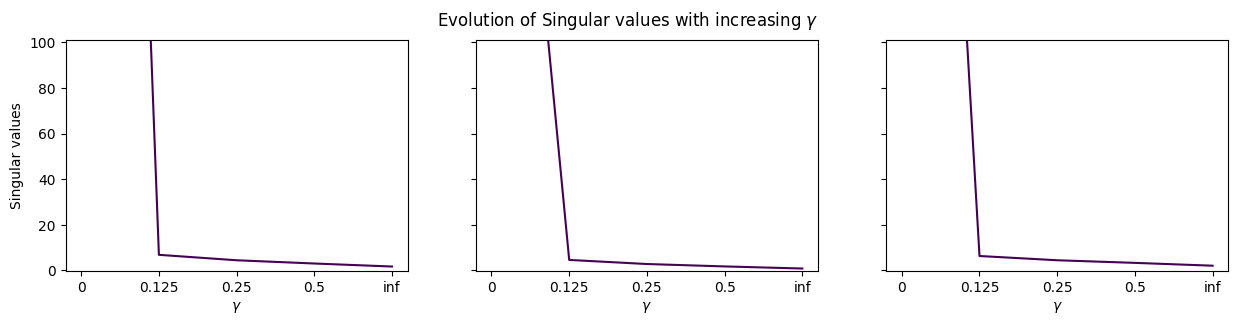

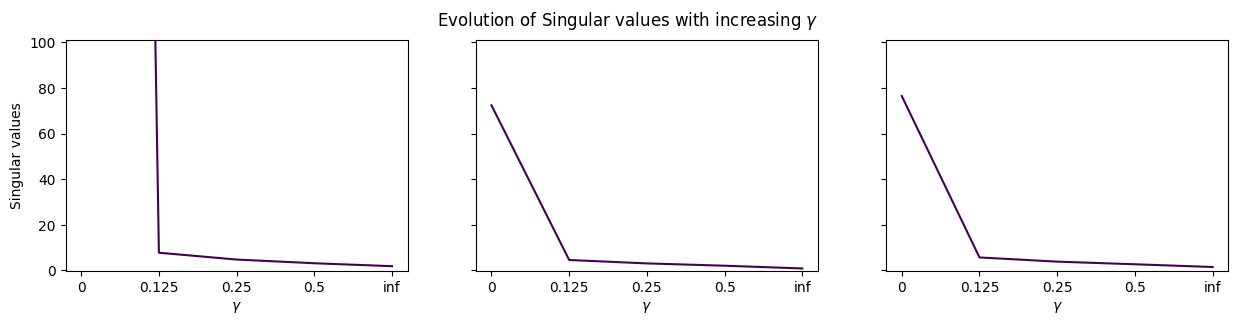

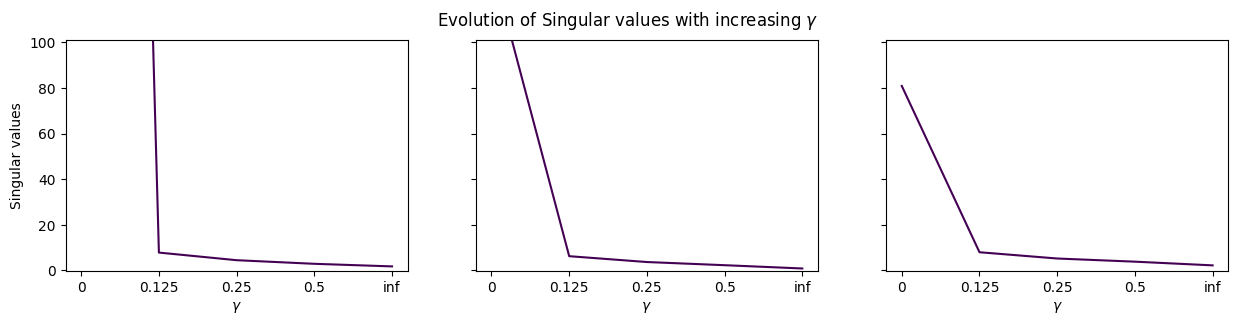

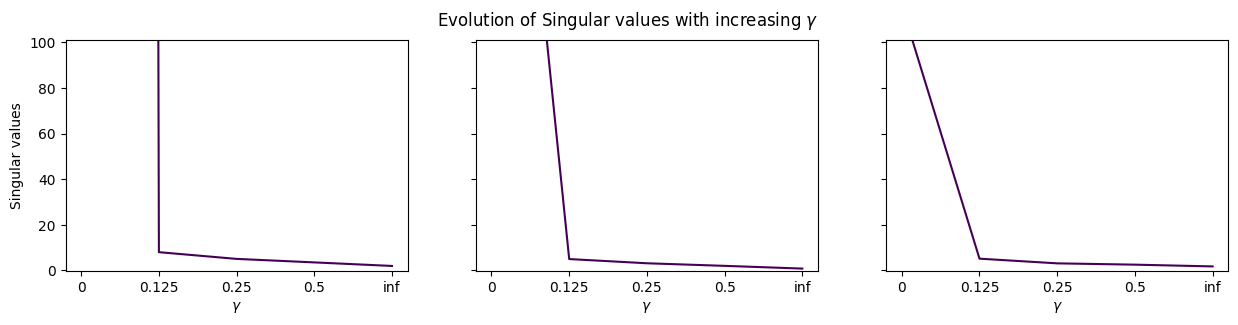

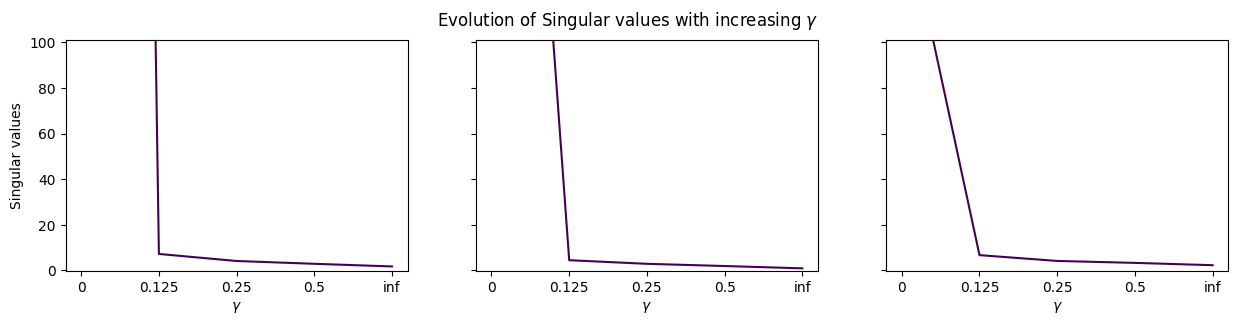

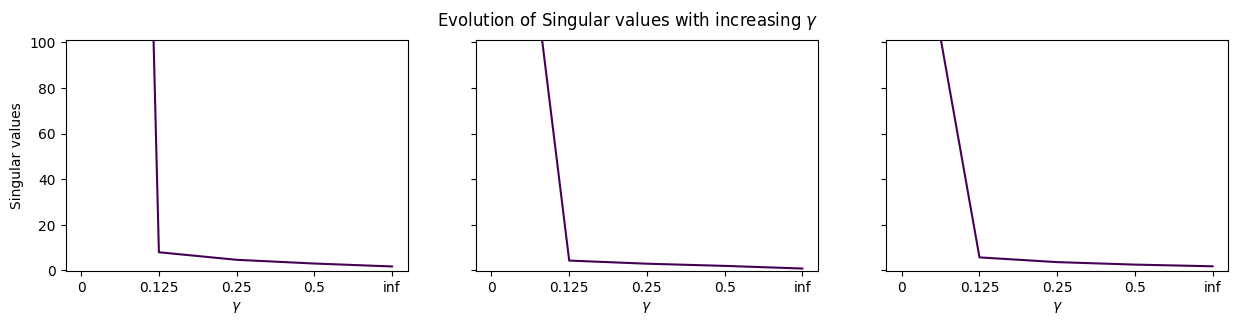

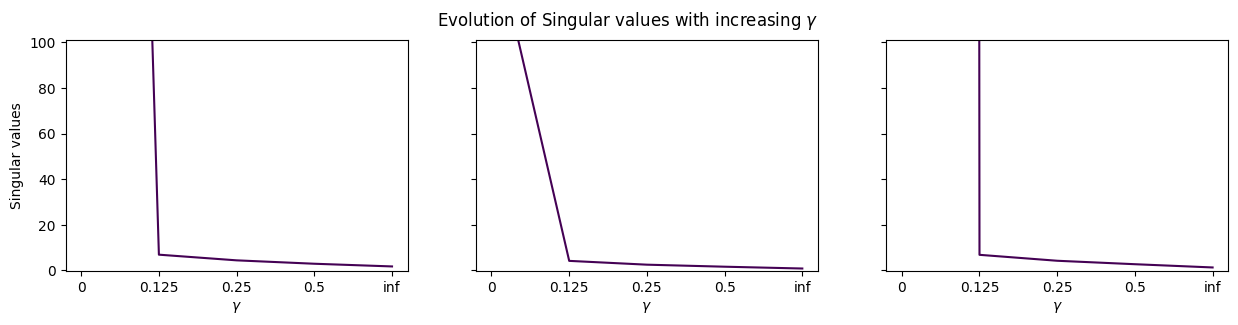

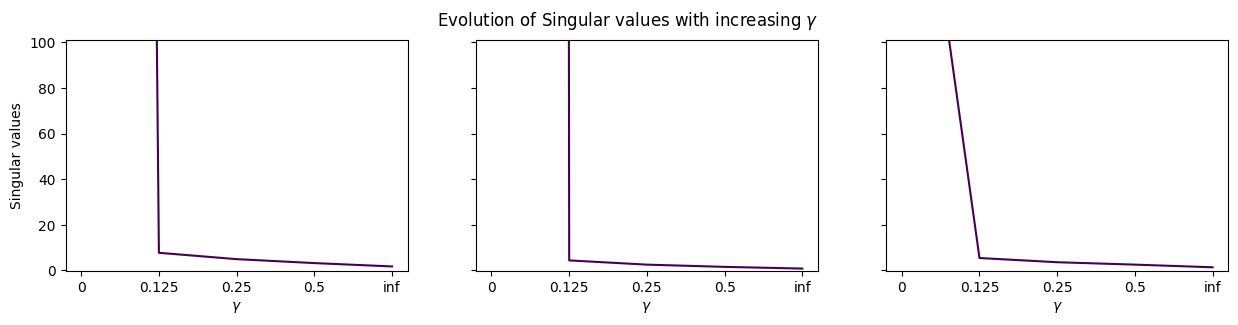

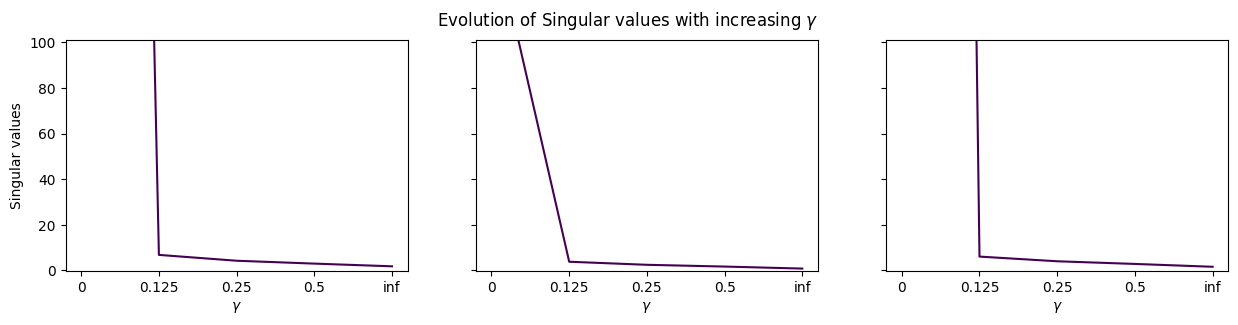

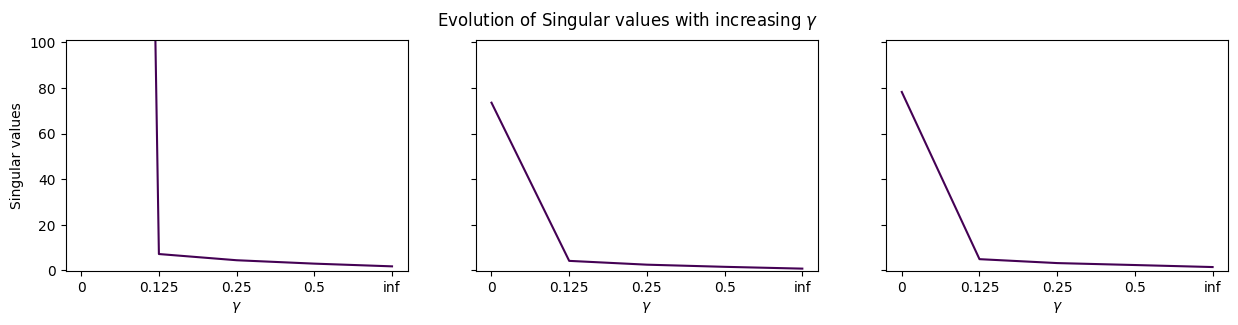

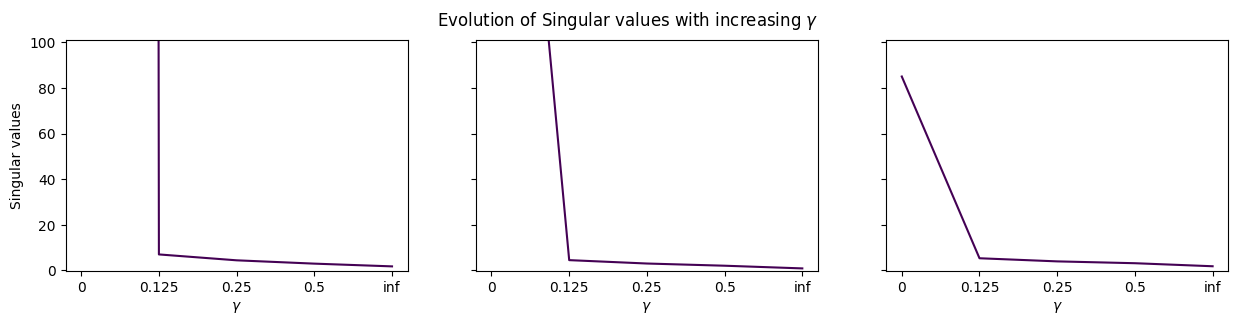

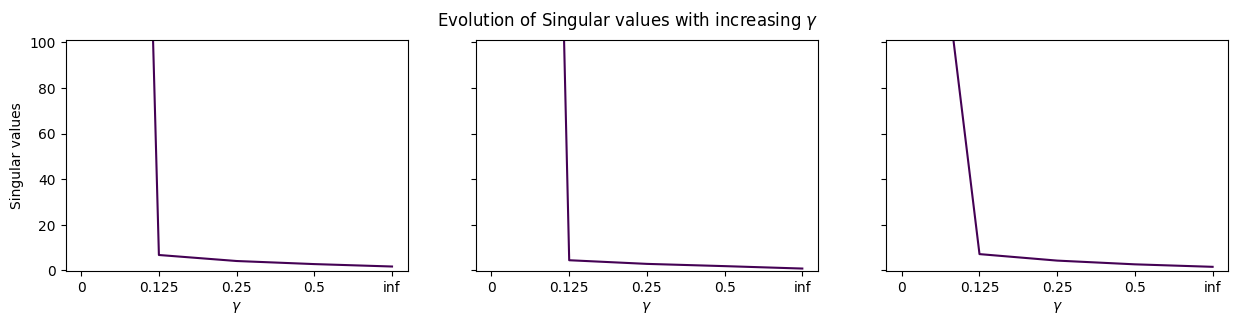

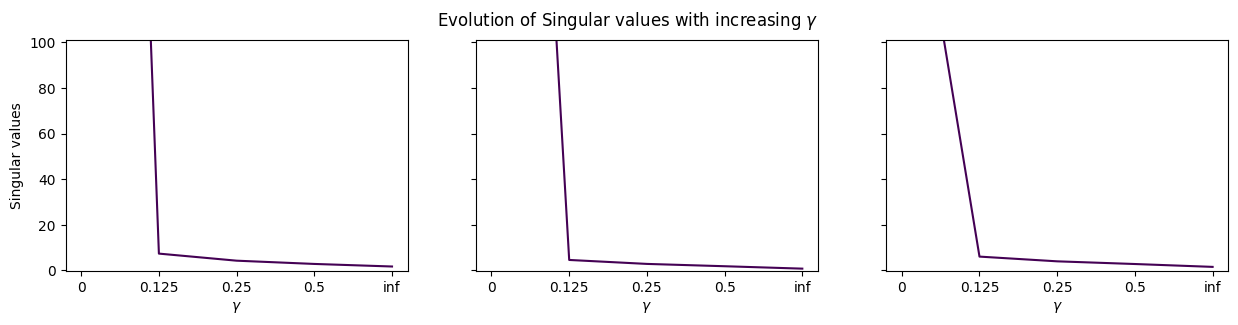

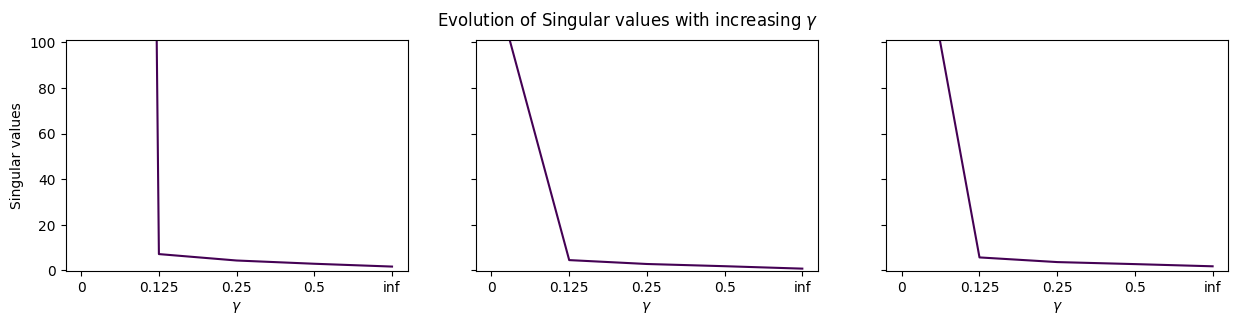

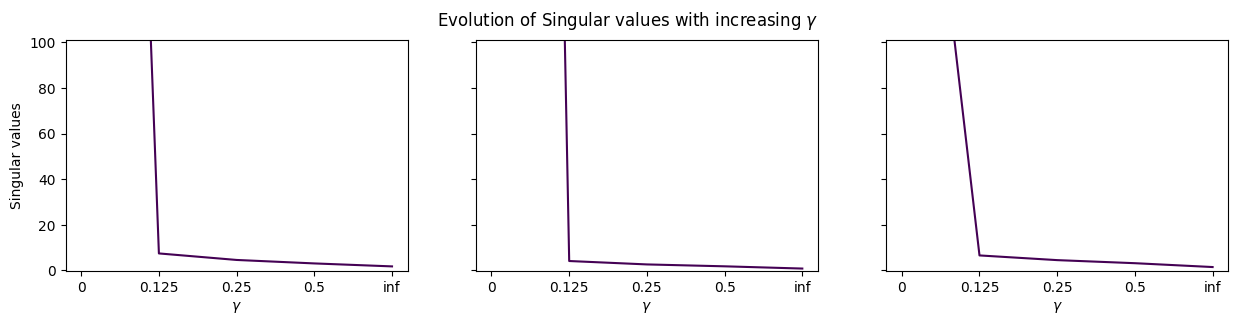

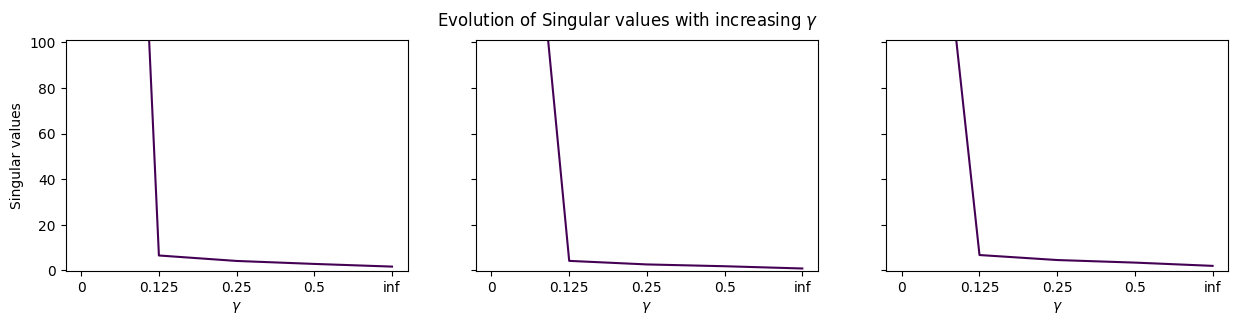

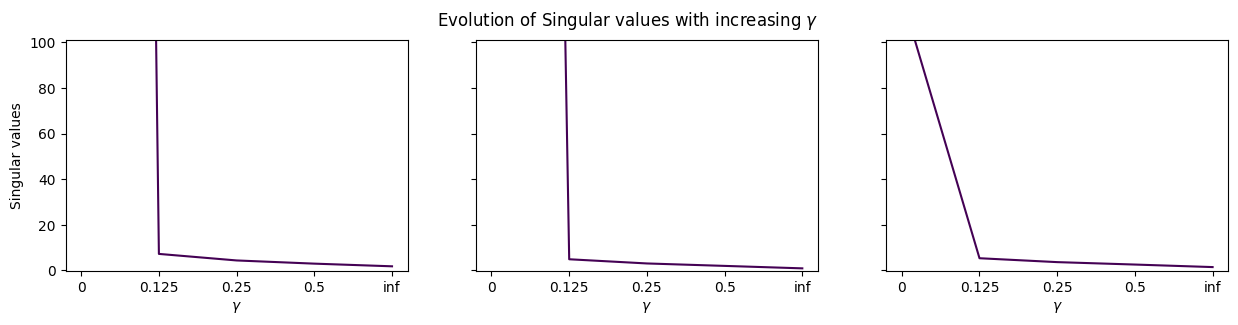

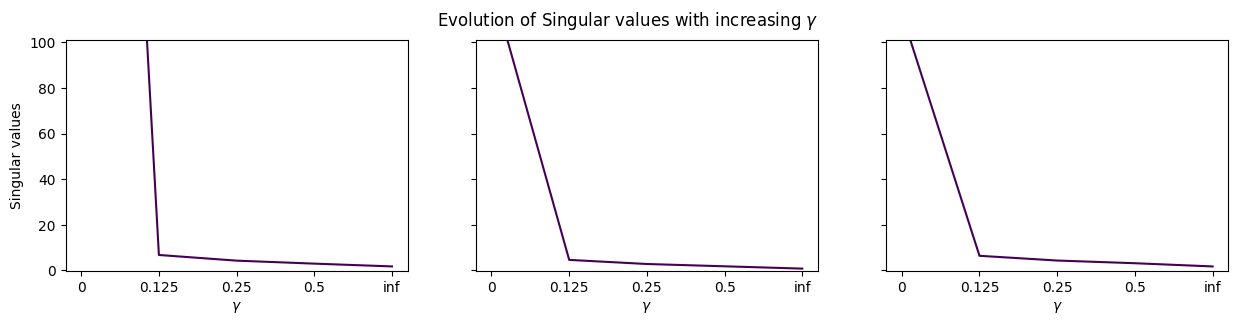

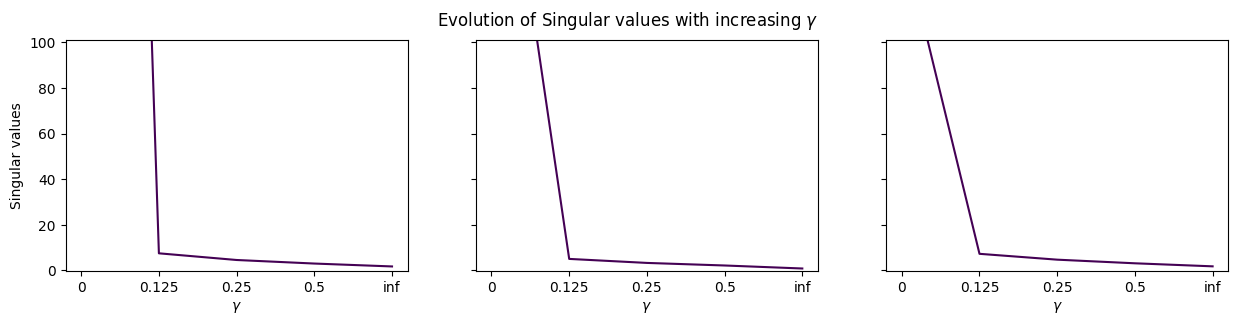

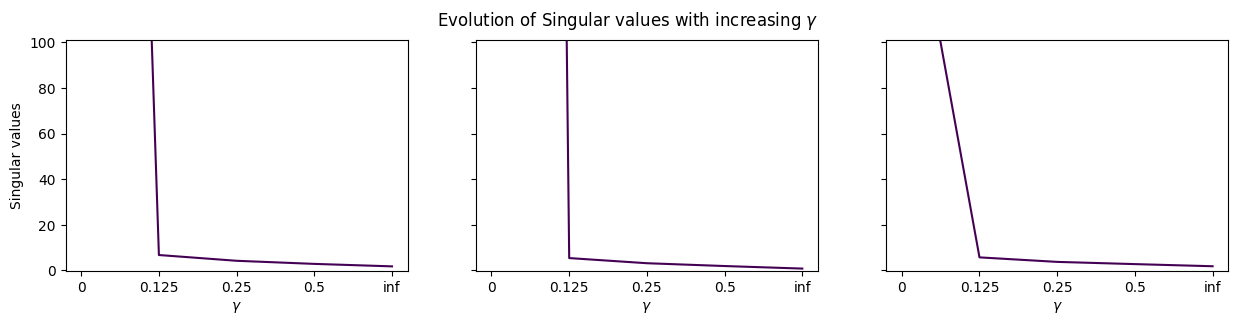

In [22]:
for i in range(20):
    plot_vals_lineplot(svals__individual_layer__gammas5__mod[:, i:i+1, :], gammas5[:], num_vals_total=400, ylim=100, yscale='linear', sharey=True)

In [362]:
# harmoic mean as of relative change as summary - y axis linear between 0 and 1
plot_multiplicative_change(svals__individual_layer__gammas5__mod, gammas5, normalize=False, hmean='', yscale='log', ylim=(0,1), sharey=True, one_plot_per='point')

/Users/jmaess/Repositories/Masterarbeit/util/util_gamma_rule.py:536: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim((ylim_l, ylim_u))


In [361]:
A, A_pos, A_neg, layers = layerwise_forward_pass(mod, data, pos_neg=True)
for i in range(len(A)):
    p, n = A_pos[i], A_neg[i]
    if p is not None and n is not None:
        p, n = p[:n_points], n[:n_points]
        mask = p+n>0
        p, n = p[mask], n[mask]
        print(i, (-n/p).mean())

1 tensor(0.0994)
3 tensor(0.7315)
5 tensor(0.6715)
7 tensor(0.6258)
9 tensor(0.6302)
11 tensor(0.6450)


### s4f3, s4f5, s4f7

In [13]:
del tqdm
from tqdm.notebook import tqdm

In [ ]:
n_points=3
mat_funcs = [partial(LRP_global_mat, model=s4f3, l_inp=l_out-2, l_out=l_out, delete_unactivated_subnetwork='mask') for l_out in s4_after_conv_layer]
LRP__individual_layer__gammas5__f3 = calc_mats_batch_functional(mat_funcs, gammas5, data[:n_points].reshape((n_points, -1)))

100%|██████████| 3/3 [01:51<00:00, 37.05s/it]


In [25]:
n_points=5
mat_funcs = [partial(LRP_global_mat, model=s4f3, l_inp=l_out-2, l_out=l_out, delete_unactivated_subnetwork=True) for l_out in s4_after_conv_layer]
LRP__individual_layer__gammas40__f3 = calc_mats_batch_functional(mat_funcs, gammas40, data[:n_points].reshape((n_points, -1)), tqdm_for='point')

100%|█████████████████████████████████████████████| 5/5 [03:37<00:00, 43.47s/it]


In [ ]:
n_points=3
mat_funcs = [partial(LRP_global_mat, model=s4f5, l_inp=l_out-2, l_out=l_out, delete_unactivated_subnetwork='mask') for l_out in s4_after_conv_layer]
LRP__individual_layer__gammas5__f5 = calc_mats_batch_functional(mat_funcs, gammas5, data[:n_points].reshape((n_points, -1)))

100%|██████████| 3/3 [02:58<00:00, 59.56s/it]


In [26]:
n_points=5
mat_funcs = [partial(LRP_global_mat, model=s4f5, l_inp=l_out-2, l_out=l_out, delete_unactivated_subnetwork=True) for l_out in s4_after_conv_layer]
LRP__individual_layer__gammas40__f5 = calc_mats_batch_functional(mat_funcs, gammas40, data[:n_points].reshape((n_points, -1)), tqdm_for='gamma')

100%|███████████████████████████████████████████| 40/40 [00:07<00:00,  5.67it/s]


In [ ]:
n_points=3
mat_funcs = [partial(LRP_global_mat, model=s4f7, l_inp=l_out-2, l_out=l_out, delete_unactivated_subnetwork='mask') for l_out in s4_after_conv_layer]
LRP__individual_layer__gammas5__f7 = calc_mats_batch_functional(mat_funcs, gammas5, data[:n_points].reshape((n_points, -1)))

100%|██████████| 3/3 [04:28<00:00, 89.33s/it]


In [27]:
n_points=5
mat_funcs = [partial(LRP_global_mat, model=s4f7, l_inp=l_out-2, l_out=l_out, delete_unactivated_subnetwork=True) for l_out in s4_after_conv_layer]
LRP__individual_layer__gammas40__f7 = calc_mats_batch_functional(mat_funcs, gammas40, data[:n_points].reshape((n_points, -1)), tqdm_for='gamma')

100%|███████████████████████████████████████████| 40/40 [01:56<00:00,  2.91s/it]


In [17]:
LRP__individual_layer__gammas40__f3.shape, LRP__individual_layer__gammas40__f3[:, :1, :1]

((1, 5, 2),
 array([[[<3284x2238 sparse array of type '<class 'numpy.float32'>'
          	with 80643 stored elements in COOrdinate format>        ]]],
       dtype=object))

In [ ]:
LRP__individual_layer__gammas5__f5.shape, LRP__individual_layer__gammas5__f5[:, :1, :1]

((3, 3, 5),
 array([[[<7840x7840 sparse array of type '<class 'numpy.float32'>'
          	with 48694 stored elements in COOrdinate format>        ]],
 
        [[<7840x7840 sparse array of type '<class 'numpy.float32'>'
          	with 174276 stored elements in COOrdinate format>       ]],
 
        [[<7840x7840 sparse array of type '<class 'numpy.float32'>'
          	with 12473 stored elements in COOrdinate format>        ]]],
       dtype=object))

In [ ]:
LRP__individual_layer__gammas5__f7.shape, LRP__individual_layer__gammas5__f7[:, :1, :1]

((3, 3, 5),
 array([[[<7840x7840 sparse array of type '<class 'numpy.float32'>'
          	with 160175 stored elements in COOrdinate format>       ]],
 
        [[<7840x7840 sparse array of type '<class 'numpy.float32'>'
          	with 125987 stored elements in COOrdinate format>       ]],
 
        [[<7840x7840 sparse array of type '<class 'numpy.float32'>'
          	with 352545 stored elements in COOrdinate format>       ]]],
       dtype=object))

In [15]:
if False:
    svals__individual_layer__gammas5__f3, _ = calc_vals_batch(LRP__individual_layer__gammas5__f3, num_vals=10, tqdm_for='point')
    save_data('s4f3', 'svals__individual_layer__gammas5', svals__individual_layer__gammas5__f3)
else:
    svals__individual_layer__gammas5__f3 = load_data('s4f3', 'svals__individual_layer__gammas5')
    
svals__individual_layer__gammas5__f3.shape

(3, 3, 5, 10)

In [28]:
args = ('s4f3', 'svals__individual_layer__gammas40')

if True: calc_vals_batch(LRP__individual_layer__gammas40__f3, num_vals=100, tqdm_for='point', save_for='point', save_func=lambda vals: save_data(*args, vals))

svals__individual_layer__gammas40__f3 = load_data(*args)
svals__individual_layer__gammas40__f3.shape

/tmp/ipykernel_338545/3371687090.py:370: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if abs_vals or svd_mode: dtype=np.float
1it [00:11, 11.20s/it]

Saving intermediate result. 0/5


2it [00:21, 10.68s/it]

Saving intermediate result. 1/5


3it [00:32, 10.77s/it]

Saving intermediate result. 2/5


4it [00:43, 10.88s/it]

Saving intermediate result. 3/5


5it [00:54, 10.96s/it]


Saving intermediate result. 4/5


1it [00:08,  8.53s/it]

Saving intermediate result. 0/5


2it [00:15,  7.75s/it]

Saving intermediate result. 1/5


3it [00:23,  7.92s/it]

Saving intermediate result. 2/5


4it [00:32,  8.16s/it]

Saving intermediate result. 3/5


5it [00:41,  8.23s/it]


Saving intermediate result. 4/5


1it [00:09,  9.07s/it]

Saving intermediate result. 0/5


2it [00:16,  8.08s/it]

Saving intermediate result. 1/5


3it [00:25,  8.42s/it]

Saving intermediate result. 2/5


4it [00:34,  8.77s/it]

Saving intermediate result. 3/5


5it [00:44,  8.92s/it]

Saving intermediate result. 4/5


(3, 5, 40, 100)

In [16]:
if False:
    svals__individual_layer__gammas5__f5, _ = calc_vals_batch(LRP__individual_layer__gammas5__f5, num_vals=10, tqdm_for='point')
    save_data('s4f5', 'svals__individual_layer__gammas5', svals__individual_layer__gammas5__f5)
else:
    svals__individual_layer__gammas5__f5 = load_data('s4f5', 'svals__individual_layer__gammas5')
    
svals__individual_layer__gammas5__f5.shape

(3, 3, 5, 10)

In [29]:
args = ('s4f5', 'svals__individual_layer__gammas40')

if True: calc_vals_batch(LRP__individual_layer__gammas40__f5, num_vals=100, tqdm_for='point', save_for='point', save_func=lambda vals: save_data(*args, vals))

svals__individual_layer__gammas40__f5 = load_data(*args)
svals__individual_layer__gammas40__f5.shape

/tmp/ipykernel_338545/3371687090.py:370: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if abs_vals or svd_mode: dtype=np.float
1it [00:06,  6.34s/it]

Saving intermediate result. 0/5


2it [00:11,  5.84s/it]

Saving intermediate result. 1/5


3it [00:17,  5.86s/it]

Saving intermediate result. 2/5


4it [00:24,  6.06s/it]

Saving intermediate result. 3/5


5it [00:30,  6.17s/it]


Saving intermediate result. 4/5


1it [00:17, 17.90s/it]

Saving intermediate result. 0/5


2it [00:36, 18.32s/it]

Saving intermediate result. 1/5


3it [00:54, 18.13s/it]

Saving intermediate result. 2/5


4it [01:12, 18.04s/it]

Saving intermediate result. 3/5


5it [01:29, 17.83s/it]


Saving intermediate result. 4/5


1it [00:02,  2.94s/it]

Saving intermediate result. 0/5


2it [00:04,  1.90s/it]

Saving intermediate result. 1/5


4it [00:04,  1.32it/s]

Saving intermediate result. 2/5
Saving intermediate result. 3/5


5it [00:05,  1.19s/it]

Saving intermediate result. 4/5


(3, 5, 40, 100)

In [17]:
if False:
    svals__individual_layer__gammas5__f7, _ = calc_vals_batch(LRP__individual_layer__gammas5__f7, num_vals=10, tqdm_for='point')
    save_data('s4f7', 'svals__individual_layer__gammas5', svals__individual_layer__gammas5__f7)
else:
    svals__individual_layer__gammas5__f7 = load_data('s4f7', 'svals__individual_layer__gammas5')
    
svals__individual_layer__gammas5__f7.shape

(3, 3, 5, 10)

In [ ]:
args = ('s4f7', 'svals__individual_layer__gammas40')

if True: calc_vals_batch(LRP__individual_layer__gammas40__f7, num_vals=100, tqdm_for='point', save_for='point', save_func=lambda vals: save_data(*args, vals))

svals__individual_layer__gammas40__f7 = load_data(*args)
svals__individual_layer__gammas40__f7.shape

/tmp/ipykernel_338545/3371687090.py:370: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if abs_vals or svd_mode: dtype=np.float
1it [00:14, 14.30s/it]

Saving intermediate result. 0/5


2it [00:22, 10.69s/it]

Saving intermediate result. 1/5


3it [00:37, 12.58s/it]

Saving intermediate result. 2/5


4it [00:53, 13.88s/it]

Saving intermediate result. 3/5


5it [01:09, 13.88s/it]


Saving intermediate result. 4/5


1it [00:12, 12.13s/it]

Saving intermediate result. 0/5


2it [00:21, 10.77s/it]

Saving intermediate result. 1/5


3it [00:34, 11.51s/it]

Saving intermediate result. 2/5


4it [00:47, 12.13s/it]

Saving intermediate result. 3/5


5it [01:00, 12.04s/it]


Saving intermediate result. 4/5


1it [00:27, 27.13s/it]

Saving intermediate result. 0/5


2it [01:12, 37.72s/it]

Saving intermediate result. 1/5


3it [01:38, 32.32s/it]

Saving intermediate result. 2/5


4it [02:02, 29.18s/it]

Saving intermediate result. 3/5


5it [02:28, 28.10s/it]

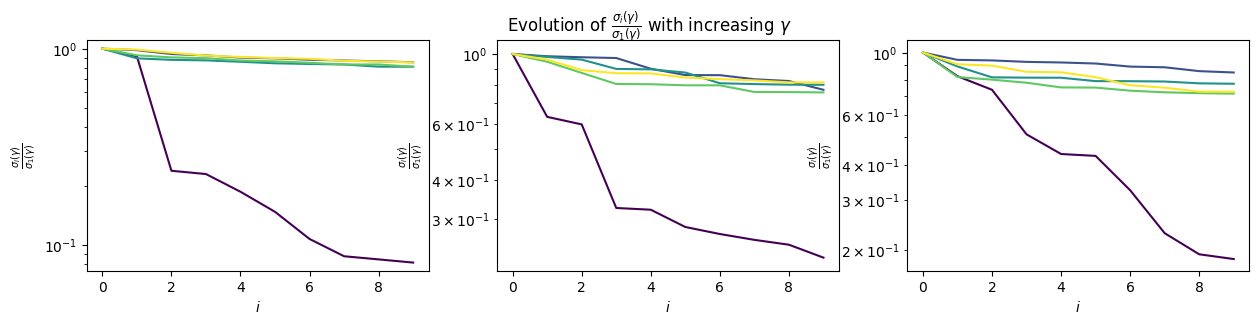

In [29]:
plot_vals_lineplot(svals__individual_layer__gammas5__f3[:, :1], gammas5
             , spectra=True
             , norm_s1=True, legend=False
            #  , norm_g0=True
             , ylim='p100'
             # , colormap='seismic'
             , yscale='log'
             )

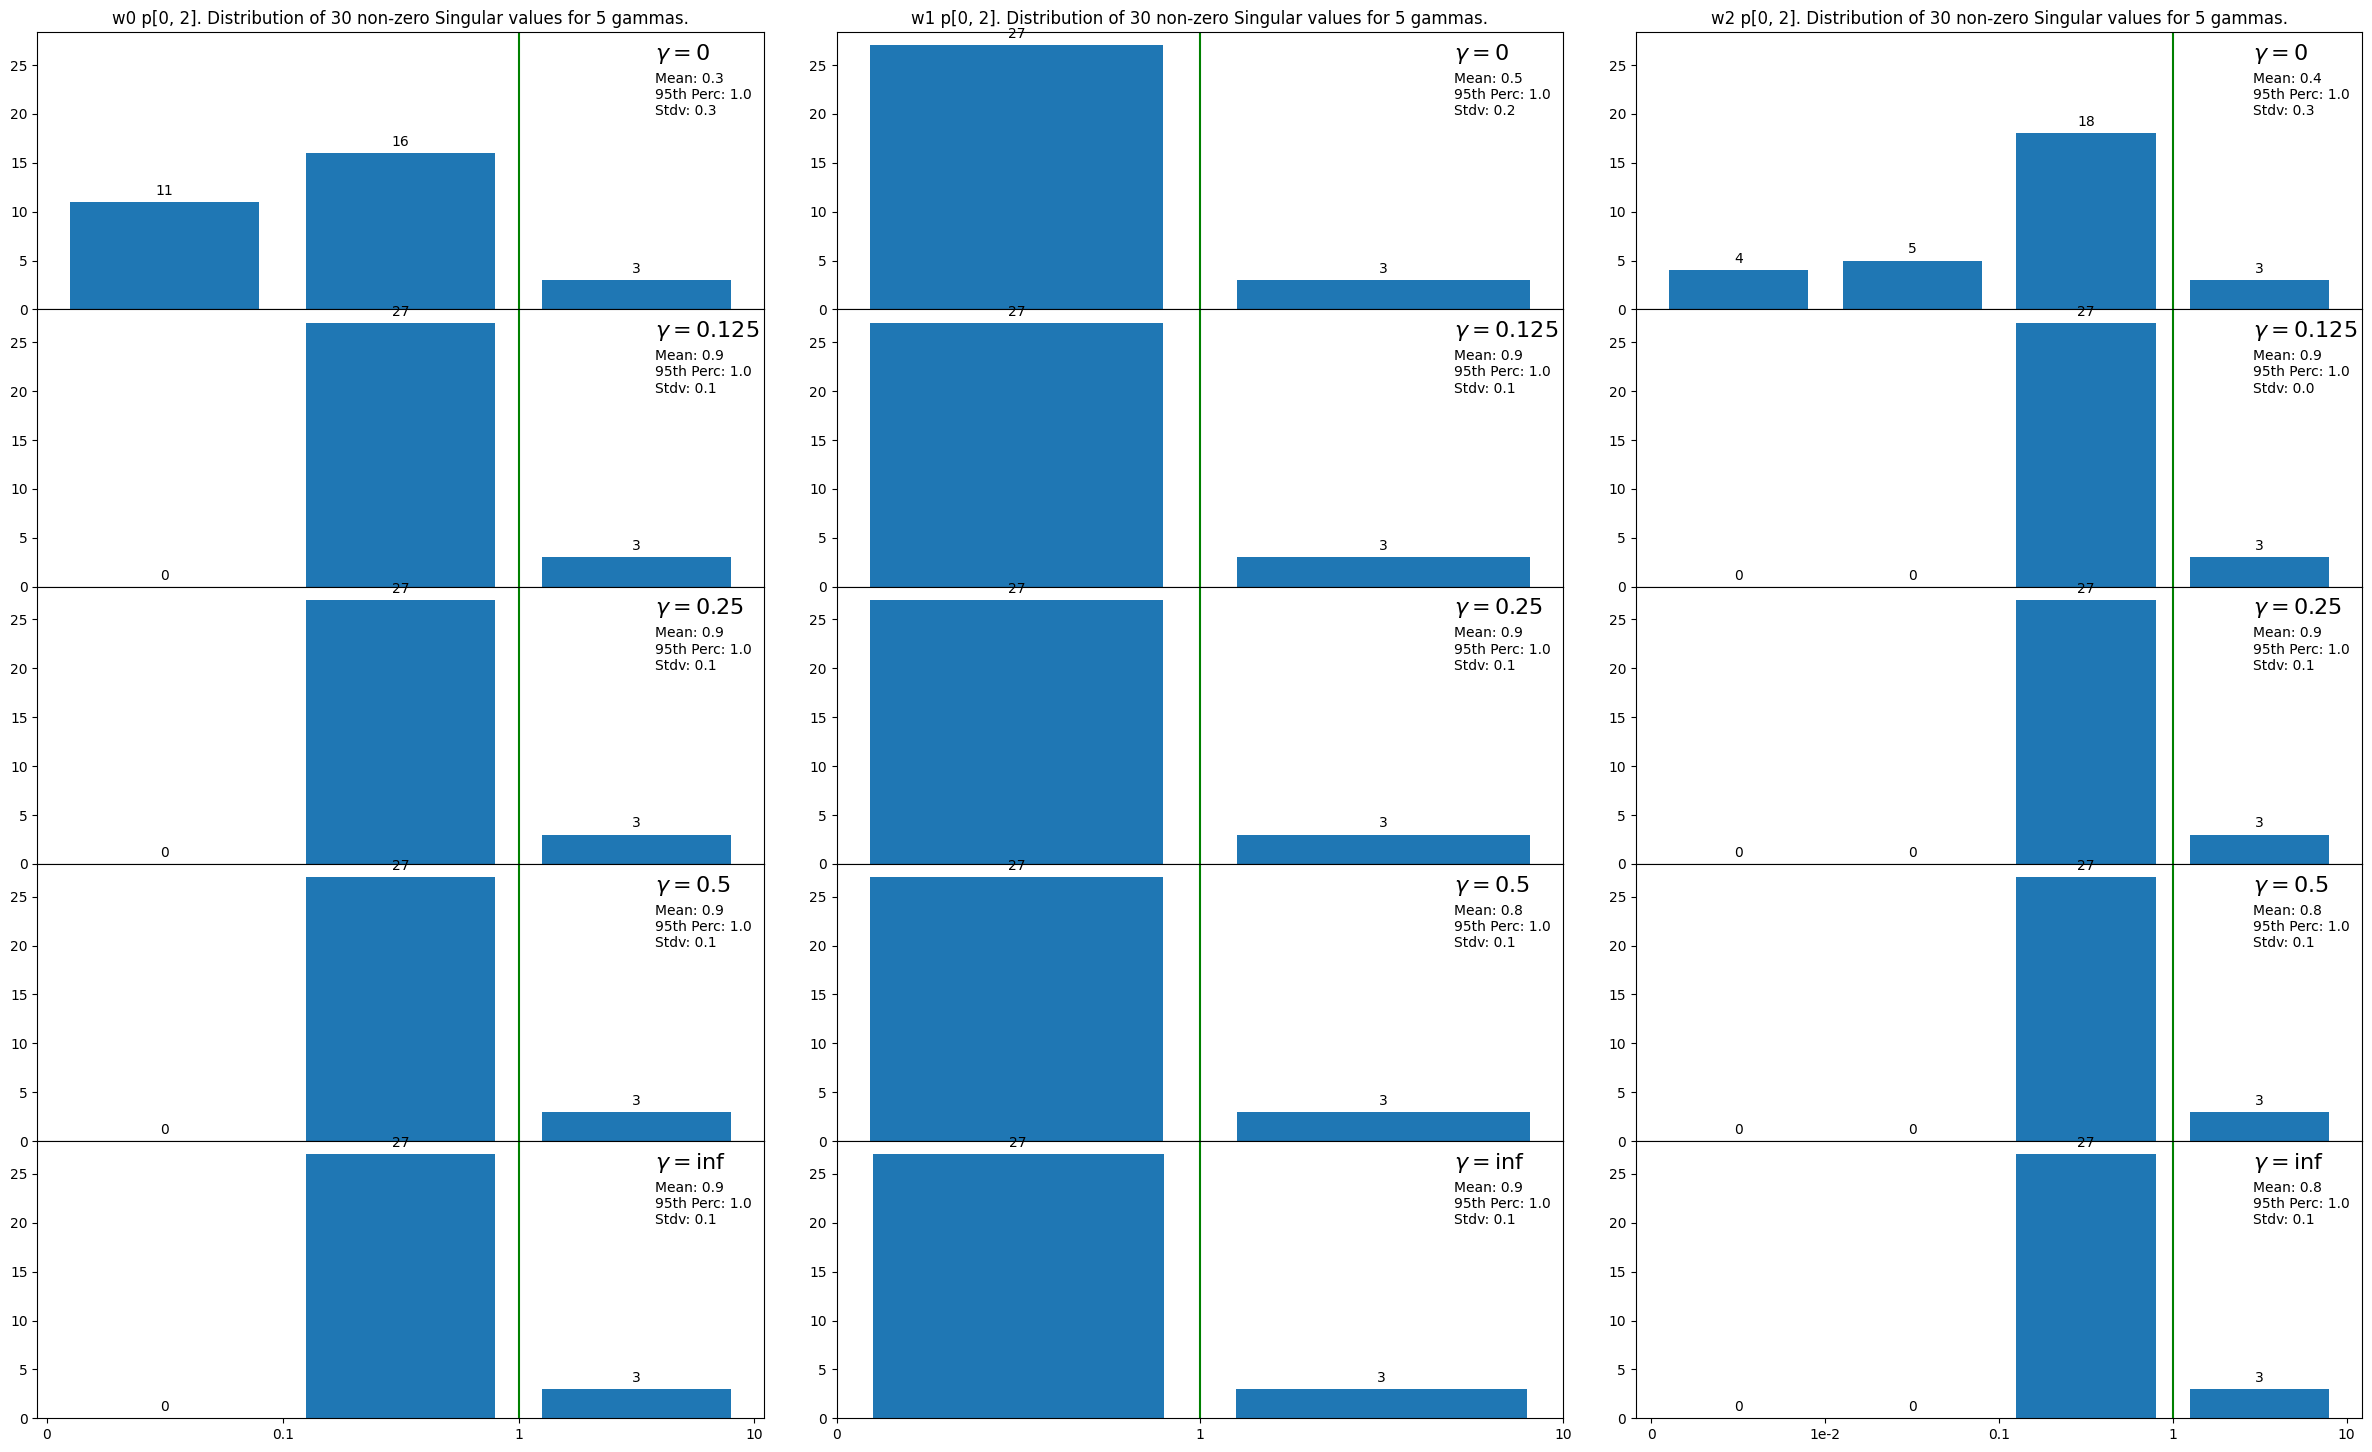

In [32]:
distribution_plot(svals__individual_layer__gammas5__f3, gammas5, aggregate_over='points', norm_s1=True, cutoff=1e-6)

In [86]:
np.percentile(svals__individual_layer__gammas5__f3[:, :, -1], [95,99, 99.9, 100])

array([2.71309268, 2.84665148, 3.07384495, 3.09908867])

In [87]:
np.percentile(svals__individual_layer__gammas5__f5[:, :, -1], [95,99, 99.9, 100])

array([2.16985426, 2.2318687 , 2.30932021, 2.31792593])

In [88]:
np.percentile(svals__individual_layer__gammas5__f7[:, :, -1], [95,99, 99.9, 100])

array([2.99064232, 3.354368  , 3.45266214, 3.46358371])

#### Absolute Svals

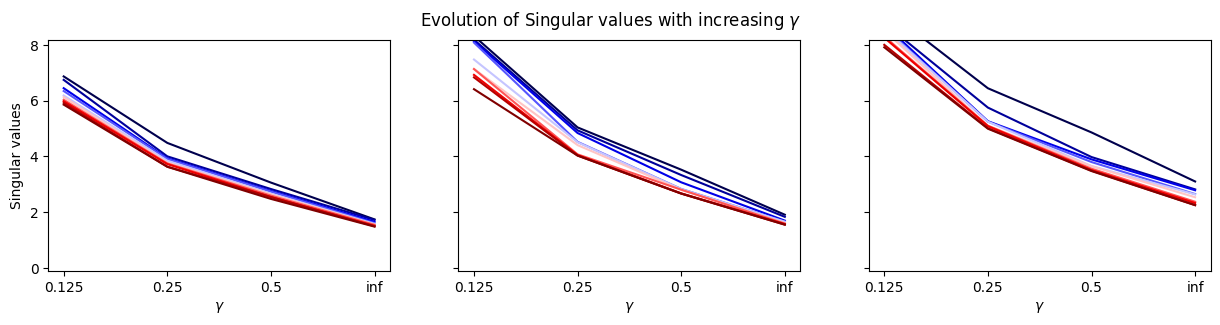

In [100]:
def plot(svals): plot_vals_lineplot(svals[:, :1, 1:], gammas5[1:], num_vals_total=400, ylim=8, colormap='seismic', sharey=True)
plot(svals__individual_layer__gammas5__f3)

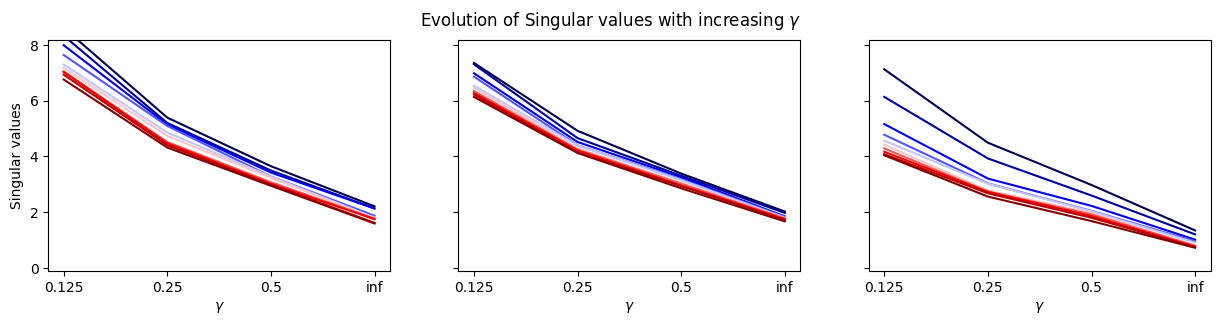

In [101]:
plot(svals__individual_layer__gammas5__f5)

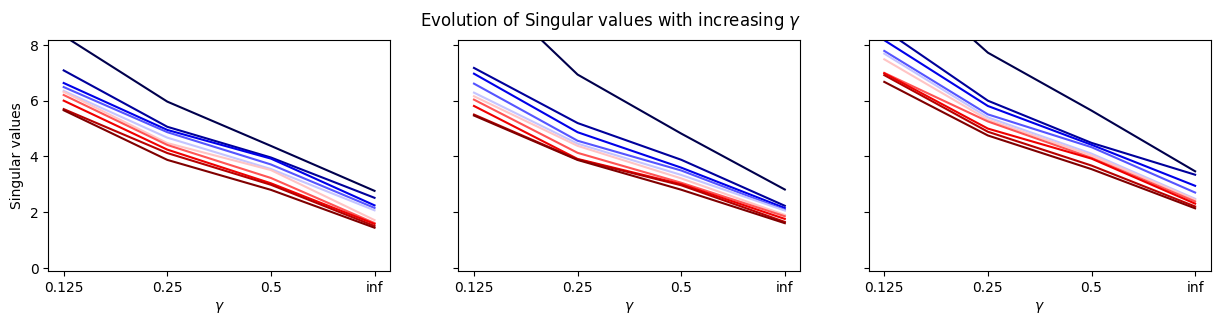

In [102]:
plot(svals__individual_layer__gammas5__f7)